## AMOC change figures



In [1]:
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import gsw

In [3]:
foldern = 'Jan22means/'

In [6]:
mnum = 3 # 0 = GFDL, 1 = MIROC, 2 = MRI, 3 = CanESM, 4 = CESM
mlist = [ "GFDL","MIROC","MRI","CanESM","CESM"]

lats = -70 # write these between -90 and 90
latn = -10  

lonw = 20 #write these between 0 and 360, sorry! # normally 20 to 100. 
lone = 150

depth = 1500

vm = 0.05
vmT = 3
vmc = 1
#fig.suptitle(mlist[mnum]+' output zonal average, '+str(lonw)+' - '+str(lone)+' E')

foldern = 'Jan22means/'
# seems like the best way to do this is to have a dictionary. Probably one dictionary for each model. This will require thinking!
# likely it's not that bad. For a start, you can write a simple code just to pull them from files! 
#Then make the dictionary when you rewrite the read from file codes to make them efficient
pl_heat_u = xr.open_dataarray(foldern + mlist[mnum]+'_heat_u.nc')
pl_heat_theta = xr.open_dataarray(foldern + mlist[mnum]+'_heat_theta.nc')
#pl_heat_pass = xr.open_dataarray(foldern + mlist[mnum]+'_heat_pass.nc')
#pl_heat_sal = xr.open_dataarray(foldern + mlist[mnum]+'_heat_sal.nc')
pl_cont_u = xr.open_dataarray(foldern + mlist[mnum]+'_cont_u.nc')
pl_cont_pass = xr.open_dataarray(foldern + mlist[mnum]+'_cont_pass.nc')
pl_cont_sal = xr.open_dataarray(foldern + mlist[mnum]+'_cont_sal.nc')
pl_cont_theta = xr.open_dataarray(foldern + mlist[mnum]+'_cont_theta.nc')
pl_NA0_theta = xr.open_dataarray(foldern + mlist[mnum]+'_NA0_theta.nc')
pl_NA0_u = xr.open_dataarray(foldern + mlist[mnum]+'_NA0_u.nc')
pl_NA50_theta = xr.open_dataarray(foldern + mlist[mnum]+'_NA50_theta.nc')
pl_NA50_u = xr.open_dataarray(foldern + mlist[mnum]+'_NA50_u.nc')

if mnum==0:
    lonfile = pl_heat_theta.lon
    latfile = pl_heat_theta.lat
    depfile = pl_heat_theta.lev
    pl_cont_sig0 = gsw.sigma0(pl_cont_sal, pl_cont_theta)
    pl_heat_sig0 = gsw.sigma0(pl_heat_sal, pl_heat_theta)
    
elif mnum in (1,2,3): 
    lonfile = pl_cont_u.longitude
    latfile = pl_cont_u.latitude
    depfile = pl_cont_u.lev
    pl_cont_sig0 = gsw.sigma0(pl_cont_sal, pl_cont_theta)
    #if mnum==1: # better solution once I make a dictionary
        #pl_cont_sig0 = MIROC_cont_sig0
    #else:
        #pl_cont_sig0 = 0*MIROC_cont_sig0
    
elif mnum ==4:
    lonfile = pl_cont_u.lon
    latfile = pl_cont_u.lat
    depfile = pl_cont_u.lev
    #pl_cont_sig0 = 0*MIROC_cont_sig0

# 25 to 65 is the region that tends to work best in Indian Ocean. 
 # actual longitude - 80 please; 305 to 345 in Indian for GFDL and MRI
# MIROC is zeroed to 60, which is annoying! 
# and CANESM to 74 hahahah what the heck ... 
# and CESM is just awful. Don't even. 1.125 degrees smh.

# should import C_ant as cant and WOCE data as WOA_TA, T6, T5 etc...


# pick actual latitudes
lonmax = [80, 360, 360, 360, 360]
lonmin = [-280, 0, 0,0,0]

if lone>lonmax[mnum]:
    lone = lone - 360
if lone<lonmin[mnum]:
    lone = lone + 360
    
if lonw>lonmax[mnum]:
    lonw = lonw - 360
if lonw<lonmin[mnum]:
    lonw = lonw + 360
    
lonecd = np.argmin(np.abs(np.array(lone - lonfile[0,:])))
lonwcd = np.argmin(np.abs(np.array(lonw - lonfile[0,:])))  
latncd = np.argmin(np.abs(np.array(latn - latfile[:,0])))
latscd = np.argmin(np.abs(np.array(lats - latfile[:,0])))

if lonwcd>lonecd:
    lonwcd = lonwcd-len(lonfile[0,:])

mylat = np.arange(latscd,latncd)
mylon = np.arange(lonwcd,lonecd)

idealdepth = [40, 48, 48, 30, 46]
idealdepth2 = [40, 48, 48, 29, 46] # just changed CanESM for now.
regdep = np.arange(0,idealdepth2[mnum])


In [7]:
levh = pl_heat_theta.lev.diff('lev')
# first, streamline. 
trans_can = pl_cont_u*np.squeeze(levh)
tmp2 = trans_can*pl_heat_theta.latitude[:,0].diff('j')
str_can = tmp2.sum('lev').cumsum('j')*0.111

trans_can = trans_can.sum('lev')

# Now let's work on that challenge, the streamline average. 

# First step is to get the coordinates of specific line. 

# interp could work over a very select increasing range
# OK I want it to work. This isn't hard. 
# basically we want the value before the max. Max less than 75 for instance. 
# there must be a simple solution for this! haha but I don't know it. 
# So at the most basic, I could grab the value closest to val, less than the max
val = 185
arr = str_can # should have shape 360,291

lm = np.argmax(np.array(arr[0:100,:]), axis=0) # lm is what I've often ended up using! Wild! 
# make sure we're still in the ACC (south of the max streamfunction in the southern ocean)

strlat = np.zeros(360)
strlat2 = np.zeros(360)

for lon in np.arange(0,360):
    # one strategy is super basic, just find the one nearest to val
    strlat[lon] = np.argmin(np.abs(np.array(arr[0:lm[lon],lon]-val)))
    # second strategy is to use interp to improve this value slightly, might be sketch in some places. 
    a = int(strlat[lon])
    strlat2[lon] = np.interp(val, arr[(a-2):(a+3),lon],np.arange(a-2,a+3) )


In [8]:
## Now get the Indian basin to be on that streamline average
# the uneven y coordinate definitely makes this more of a challenge! 
# the best option is going to be interpolating the points onto a grid, probably 0.5 degrees. I think we can do linear.
# this is not hard but I don't want to do it at the moment. 

# 2 options: 
# 1 is to just grab a bunch of data on either side ... but that's ugly. 
# second option is, basically for each i (longitude), grab the SAF longitude somehow (maybe center/north edge of that max grid cell )
# then basically create an array np.array(-15,15), add that to the SAF, and then make that what you're interpolating onto. 
# then save that output of interpolation. 
# I think we just want to do it for each depth separately 

sos= 15 # integers please
nos = 25
wind = np.arange(-sos,nos)
winddif = np.arange(-sos-0.5, nos+0.5)
heat_T_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
cont_T_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
cont_pass_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
cont_U_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
heat_U_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
cont_T_dif_can_str = np.zeros([len(regdep), sos+nos+1, len(mylon)])
NA0_T_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
NA0_U_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
NA50_T_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])
NA50_U_can_str = np.zeros([len(regdep), sos+nos, len(mylon)])

for i in np.arange(0,len(mylon)-1):
    a = float(pl_heat_theta.latitude.isel(j=int(lm[mylon[i]]), i =0)) # use lm[mylon[i]] or strlat
    winda = a+ wind
    winddifa = a+ winddif
    for l in np.arange(0,len(regdep)):
        heat_T_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_heat_theta.isel(lev=l, i=mylon[i]))
        cont_T_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_cont_theta.isel(lev=l, i=mylon[i]))
        cont_pass_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_cont_pass.isel(lev=l, i=mylon[i]))
        cont_T_dif_can_str[l,:,i] = np.interp(winddifa, pl_heat_theta.latitude.isel(i=i), pl_cont_theta.isel(lev=l, i=mylon[i]))
        heat_U_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_heat_u.isel(lev=l, i=mylon[i]))
        cont_U_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_cont_u.isel(lev=l, i=mylon[i]))
        NA0_T_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_NA0_theta.isel(lev=l, i=mylon[i]))
        NA0_U_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_NA0_u.isel(lev=l, i=mylon[i]))
        NA50_T_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_NA50_theta.isel(lev=l, i=mylon[i]))
        NA50_U_can_str[l,:,i] = np.interp(winda, pl_heat_theta.latitude.isel(i=i), pl_NA50_u.isel(lev=l, i=mylon[i]))
        #SAFy=np.interp(np.arange(lonw,lone)+0.5,orsiSAFx,orsiSAFy)

    #WOA_sal_str[:,:,i] = sald[wocedep, a-sos:a+nos, wocelon[i]]
    #heat_T_can_str[:,:,i] = pl_heat_theta[regdep, a-sos:a+nos,wocelon[i]]
    #cont_T_can_str[:,:,i] = pl_cont_theta[regdep, a-sos:a+nos,wocelon[i]]
    #cont_pass_can_str[:,:,i] = pl_cont_pass[regdep, a-sos:a+nos,wocelon[i]]

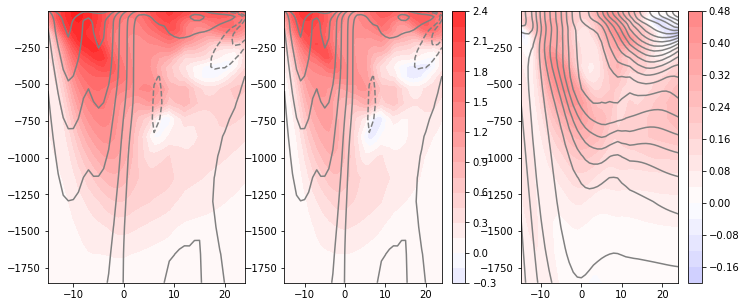

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,5)) 
plt.set_cmap('bwr')
vm = 3
# np.concatenate([np.arange(37,320),np.arange(0,35)])
tmplon = np.arange(60,130) # 20 is 0 # - np.nanmean(cont_T_can_str[:,:,tmplon],2)- np.nanmean(cont_pass_can_str[:,:,tmplon],2)
#   - np.nanmean(cont_pass_can_str,2) #  np.nanmean(heat_T_can_str[:,:,tmplon],2)- np.nanmean(cont_T_can_str[:,:,tmplon],2) 
axs[0].contour(wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(cont_U_can_str[:,:,tmplon],2) , levels = [-0.075,-0.05,-0.03,-0.02,0,0.02,0.05,0.075,0.1,0.125], colors='gray')
#plt.contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(np.diff(cont_T_dif_can_str[:,:,tmplon],axis=1),2),vmin = -vm, vmax = vm, levels=20)
#plt.contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(cont_pass_can_str[:,:,tmplon],2) ,vmin = -vm, vmax = vm, levels=20)
axs[0].contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(heat_T_can_str[:,:,tmplon],2) - np.nanmean(cont_T_can_str[:,:,tmplon],2), vmin = -vm, vmax = vm, levels=20)

# 
axs[1].contour(wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(cont_U_can_str[:,:,tmplon],2) , levels = [-0.075,-0.05,-0.03,-0.02,0,0.02,0.05,0.075,0.1,0.125], colors='gray')
#plt.contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(np.diff(cont_T_dif_can_str[:,:,tmplon],axis=1),2),vmin = -vm, vmax = vm, levels=20)
#plt.contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(cont_pass_can_str[:,:,tmplon],2) ,vmin = -vm, vmax = vm, levels=20)
B= axs[1].contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(NA0_T_can_str[:,:,tmplon],2) - np.nanmean(cont_T_can_str[:,:,tmplon],2), vmin = -vm, vmax = vm, levels=20)
vm = 1
fig.colorbar(B, ax=axs[1])
axs[2].contour(wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(cont_T_can_str[:,:,tmplon],2) , levels = 28, colors='gray')
C= axs[2].contourf( wind, -pl_heat_theta.lev.isel(lev=regdep), np.nanmean(heat_T_can_str[:,:,tmplon],2)- np.nanmean(NA0_T_can_str[:,:,tmplon],2), vmin = -vm, vmax = vm, levels=20)


fig.colorbar(C, ax=axs[2])


# sure, that's fine? 

In [10]:
ls /nfs/data/FAFMIP/faf-heat-NA0pct/*MRI*


/nfs/data/FAFMIP/faf-heat-NA0pct/hfcorr_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_185001-191912.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/hfcorr_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gr_185001-191912.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/hfds_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_185001-191912.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/hfds_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gr_185001-191912.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/opottempdiff_Oyr_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_1850-1919.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/opottemppadvect_Oyr_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_1850-1919.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/opottemppmdiff_Oyr_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_1850-1919.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/opottemprmadvect_Oyr_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_1850-1919.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/tauuo_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_185001-191912.nc
/nfs/data/FAFMIP/faf-heat-NA0pct/tauvo_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_

In [11]:
ls Jan22means/*NA50*

Jan22means/CanESM_NA50_theta.nc  Jan22means/GFDL_NA50_v.nc
Jan22means/CanESM_NA50_u.nc      Jan22means/MRI_NA50_theta.nc
Jan22means/GFDL_NA50_u.nc        Jan22means/MRI_NA50_u.nc


In [12]:
#heat_u_tmp6 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA0pct/thetao_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_185001-191912.nc")
#heat_u_tmp7 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA50pct/vo_Omon_GFDL-ESM2M_faf-heat-NA50pct_r1i1p1f1_gn_016101-017012.nc")
#MRI_NA50_theta = heat_u_tmp6.thetao.isel(time=np.arange(600,840)).mean(dim='time')# + heat_u_tmp7.vo.mean(dim='time'))/2
##
#foldern = 'Jan22means/'
#MRI_NA50_theta.to_netcdf(foldern+'MRI_NA0_theta.nc')
#

In [13]:
#heat_u_tmp6 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA50pct/vo_Omon_GFDL-ESM2M_faf-heat-NA50pct_r1i1p1f1_gn_014101-016012.nc")
#heat_u_tmp7 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA50pct/vo_Omon_GFDL-ESM2M_faf-heat-NA50pct_r1i1p1f1_gn_016101-017012.nc")
#GFDL_NA50_theta = (heat_u_tmp6.vo.isel(time=np.arange(120,240)).mean(dim='time') + heat_u_tmp7.vo.mean(dim='time'))/2
###
#GFDL_NA50_theta.to_netcdf(foldern+'GFDL_NA50_v.nc')
##

In [14]:
#heat_u_tmp6 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA0pct/uo_Omon_MRI-ESM2-0_faf-heat-NA0pct_r1i1p1f1_gn_185001-191912.nc")
#heat_u_tmp7 = xr.open_dataset("/nfs/data/FAFMIP/faf-heat-NA50pct/vo_Omon_GFDL-ESM2M_faf-heat-NA50pct_r1i1p1f1_gn_016101-017012.nc")
#MRI_NA0_theta = heat_u_tmp6.uo.isel(time=np.arange(600,840)).mean(dim='time')# + heat_u_tmp7.vo.mean(dim='time'))/2
##
#MRI_NA0_theta.to_netcdf(foldern+'MRI_NA0_u.nc')
#

In [15]:
pl_NA0 = foldern

## not sure what this stuff here is!! 

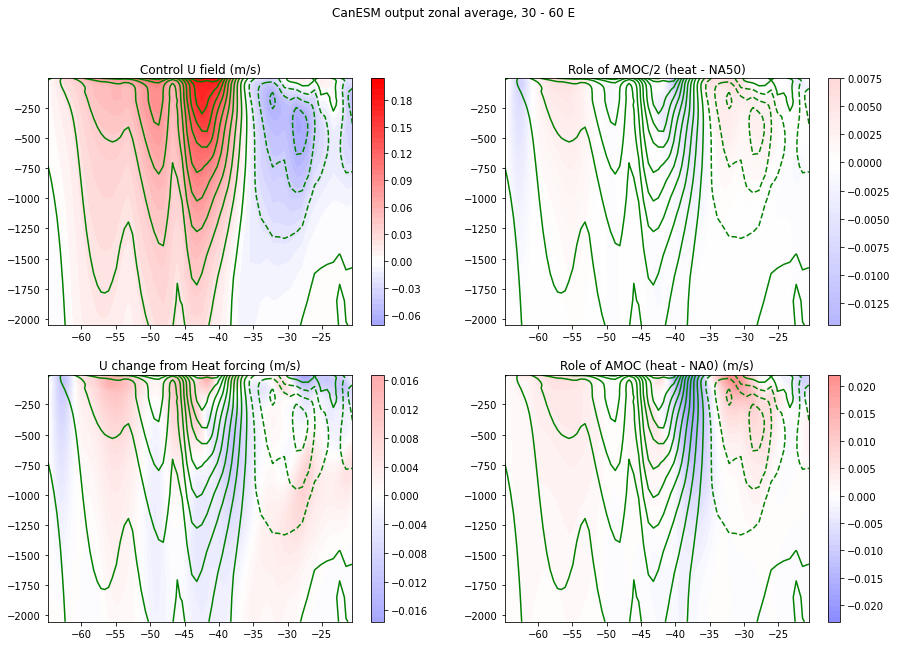

In [16]:
# zonal averages. Nice figure.

contT = xr.open_dataset('str_theta.nc')

mnum = 3 # 0 = GFDL, 1 = MIROC, 2 = MRI, 3 = CanESM, 4 = CESM
mlist = [ "GFDL","MIROC","MRI","CanESM","CESM"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10)) 

lats = -65
latn = -20  

lone = 30
lonw = 60

vm = 0.05
vmT = 3
vmc = 0.2


pl_heat_u = xr.open_dataarray(foldern + mlist[mnum]+'_heat_u.nc')
pl_heat_theta = xr.open_dataarray(foldern + mlist[mnum]+'_heat_theta.nc')
pl_heat_pass = xr.open_dataarray(foldern + mlist[mnum]+'_heat_pass.nc')
pl_heat_sal = xr.open_dataarray(foldern + mlist[mnum]+'_heat_sal.nc')
pl_NA0_u = xr.open_dataarray(foldern + mlist[mnum]+'_NA0_u.nc')
pl_NA50_u = xr.open_dataarray(foldern + mlist[mnum]+'_NA50_u.nc')

pl_cont_u = xr.open_dataarray(foldern + mlist[mnum]+'_cont_u.nc')
pl_cont_theta = xr.open_dataarray(foldern + mlist[mnum]+'_cont_theta.nc')
pl_cont_sal = xr.open_dataarray(foldern + mlist[mnum]+'_cont_sal.nc')



if mnum==0:
    lonfile = contT.lon
    latfile = contT.lat
    depfile = contT.lev
    pl_cont_sig0 = gsw.sigma0(pl_cont_sal, pl_cont_theta)
    
    
elif mnum in (1,2,3): 
    lonfile = pl_cont_u.longitude
    latfile = pl_cont_u.latitude
    depfile = pl_cont_u.lev
    pl_cont_sig0 = gsw.sigma0(pl_cont_sal, pl_cont_theta)
    #if mnum==1: # better solution once I make a dictionary
        #pl_cont_sig0 = MIROC_cont_sig0
    #else:
        #pl_cont_sig0 = 0*MIROC_cont_sig0
    
elif mnum ==4:
    lonfile = pl_cont_u.lon
    latfile = pl_cont_u.lat
    depfile = pl_cont_u.lev
    pl_cont_sig0 = 0*MIROC_cont_sig0

# 25 to 65 is the region that tends to work best in Indian Ocean. 
 # actual longitude - 80 please; 305 to 345 in Indian for GFDL and MRI
# MIROC is zeroed to 60, which is annoying! 
# and CANESM to 74 hahahah what the heck ... 
# and CESM is just awful. Don't even. 1.125 degrees smh.

# pick actual latitudes
lonmax = [80, 360, 360, 360, 360]
lonmin = [-280, 0, 0,0,0]

if lone>lonmax[mnum]:
    lone = lone - 360
if lone<lonmin[mnum]:
    lone = lone + 360
    
if lonw>lonmax[mnum]:
    lonw = lonw - 360
if lonw<lonmin[mnum]:
    lonw = lonw + 360
    
lonecd = np.argmin(np.abs(np.array(lone - lonfile[0,:])))
lonwcd = np.argmin(np.abs(np.array(lonw - lonfile[0,:])))  
latncd = np.argmin(np.abs(np.array(latn - latfile[:,0])))
latscd = np.argmin(np.abs(np.array(lats - latfile[:,0])))

if lonecd>lonwcd:
    lonecd = lonecd-len(lonfile[0,:])

mylat = np.arange(latscd,latncd)
mylon = np.arange(lonecd,lonwcd)

idealdepth = [40, 48, 48, 30, 46]
regdep = np.arange(0,idealdepth[mnum])
plt.set_cmap('bwr')
 

fig.suptitle(mlist[mnum]+' output zonal average, '+str(lone)+' - '+str(lonw)+' E')

depf = [-1, -1, -1, -1, -0.01]
yy, zz = np.meshgrid(latfile[mylat,0],  depf[mnum]* depfile[regdep])
yy2, zz2 = np.meshgrid(latfile[np.arange(lats,latn-1),0],  depf[mnum]* depfile[regdep])

plot1 = np.mean(pl_cont_u[:,:,mylon],2) 
#toPl = np.diff(toPl,1)
A= axs[0,0].contourf(yy, zz, plot1[regdep,mylat] , vmin=-vmc, vmax=vmc, levels = 50)

toPl3 = np.mean(-pl_NA0_u[:,:,mylon]+ pl_heat_u[:,:,mylon],2)
D = axs[1,1].contourf(yy, zz, toPl3[regdep,mylat] ,vmin=-vm, vmax=vm, levels = 50)

# one degree shift, a little complex. 

toPl4 = np.mean(-pl_NA50_u[:,:,mylon]+ pl_heat_u[:,:,mylon],2)
B = axs[0,1].contourf(yy, zz, toPl4[regdep,mylat] ,vmin=-vm, vmax=vm, levels = 50)
#axs[1,1].contour(yy, zz, np.mean(cont_sig0[regdep,mylat,mylon],2),np.linspace(25, 28, 12), colors='green')
toPl2 = np.mean(pl_heat_u[:,:,mylon]  - pl_cont_u[:,:,mylon],2)
C =axs[1,0].contourf(yy, zz, toPl2[regdep,mylat] ,vmin=-vm, vmax=vm, levels = 50)


#F =axs[2,1].contourf(yy, zz, np.mean(pl_heat_delu[regdep,:,:],2) ,vmin=-vm, vmax=vm, levels = 50)

plt.set_cmap("bwr")
#plt.clim([-2,2])

# contours are for reference
for i in (0,1):
    for j in (0,1):
        axs[i,j].contour(yy, zz, np.mean(pl_cont_u[regdep,mylat,mylon],2),levels=15, colors='green')

#axs[0].contour(yy, zz, np.mean(all_sig0[regdep,mylat,mylon],2),np.linspace(23, 28, 20), colors='green')
axs[0,0].set_title("Control U field (m/s)") # Need to check the actual latitude. 
axs[1,0].set_title("U change from Heat forcing (m/s)") # that took a while to find, equivalent to caxis in MATLAB I think 
axs[1,1].set_title("Role of AMOC (heat - NA0) (m/s)")#cb = fig.colorbar(fig,shrink = 0.5)
axs[0,1].set_title("Role of AMOC/2 (heat - NA50)")


fig.colorbar(A, ax=axs[0,0])
fig.colorbar(B, ax=axs[0,1])
fig.colorbar(C, ax=axs[1,0])
fig.colorbar(D, ax=axs[1,1])



In [9]:
## very time consuming, watch out! 

import scipy.io as sio
Natl=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstnorthatlanticexplast40years.mat')
#Indp=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstindpacexplast40years.mat')

In [10]:
climT_natl = Natl['temp4dmeaninterp']
#expT_natl = Natl['temp4dmeanwarminginterp']
dep_natl = np.squeeze(Natl['depth'])
lat_natl = np.squeeze(Natl['latinterp'])
lon_natl = np.squeeze(Natl['loninterp'])

#climT_natl = Indp['temp4dmeaninterp']
##expT_natl = Natl['temp4dmeanwarminginterp']
#dep_natl = np.squeeze(Indp['depth'])
#lat_natl = np.squeeze(Indp['latinterp'])
#lon_natl = np.squeeze(Indp['loninterp'])
#expT_indp = Indp['temp4dmeanwarminginterp']

# Ue4dmean, Ue4dmeanwarming, Vn4dmean, Vnd4meanwarming, salt4dmean, salt4dmeaninterp, temp4dmean, temp4dmeanwarming. 
# also stuff like sea level, more interpolated things, etc.  # temp4dmeanwarminginterp

In [19]:
#SST4k = sio.loadmat('/nfs/data/OGCM/globalwarmingsst4kexplast40years.mat')

In [20]:
#SST = sio.loadmat('/nfs/data/OGCM/globalwarmingsstexplast40years.mat')

In [21]:
## getting the passive tracer! 
import mat73
Natl = mat73.loadmat('/nfs/data/OGCM/globalwarmingssssstnorthatlanticexpyearly1to150simple.mat')
passT_natl = Natl['trac4dmeaninterp']

In [22]:
#SSTna = sio.loadmat('/nfs/data/OGCM/globalwarmingsstnorthatlanticexplast40years.mat')
SSSna = sio.loadmat('/nfs/data/OGCM/globalwarmingsssnorthatlanticexplast40years.mat')

In [23]:
climU_natl = Indp['u4dmeaninterp']
#expU_natl = Natl['u4dmeanwarminginterp']
expU_indp = Indp['u4dmeanwarminginterp']
expU_sst4k = SST4k['u4dmeanwarminginterp']
#dep_natl = np.squeeze(Natl['depth'])
climaU_natl = np.mean(climU_natl,3)
#expaU_natl = np.mean(expU_natl,3)
expaU_indp = np.mean(expU_indp,3)
expaU_sst4k = np.mean(expU_sst4k,3)

expU_sst = SST['u4dmeanwarminginterp']
expaU_sst = np.mean(expU_sst,3)

expU_sstna = SSTna['u4dmeanwarminginterp'] # this one is pretty weak! 
expaU_sstna = np.mean(expU_sstna,3)

expU_sssna = SSSna['u4dmeanwarminginterp'] # this one is pretty weak! 
expaU_sssna = np.mean(expU_sssna,3)

NameError: name 'SSTna' is not defined

In [ ]:
# we can see that there's a clear shift around 100-170 and 20-60. (maybe 90s are ok too.)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6)) 

plt.set_cmap('bwr')
qlon = range(30,70)
qlat = range(10,70)
qlev = range(0,35)
ctl = np.nanmean(climaU_natl[qlon,:,:], 0)
ctl = ctl[qlat,:]
toPl = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_sstna[qlon,:,:],0)
toPl = toPl[qlat,:]

toPl2 = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_sssna[qlon,:,:],0)
toPl2 = toPl2[qlat,:]

vm = 0.03
axs[0].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
axs[1].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
A = axs[0].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl[:, qlev]), vmin = -vm, vmax = vm, levels=30)
B = axs[1].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl2[:, qlev]), vmin = -vm, vmax = vm, levels=30)
plt.colorbar(A)

In [ ]:
#m = open('/nfs/data/OGCM/readme.txt')
#m.read()

In [41]:
# annual mean rather than climatology
climaT_natl = np.mean(climT_natl,3)
#expaT_natl = np.mean(expT_natl,3)
#passaT_natl = np.mean(passT_natl,3)
#expaT_indp = np.mean(expT_indp,3)
#climaT_natl[:, :,:].shape

In [ ]:
climU_natl = Natl['u4dmeaninterp']
expU_natl = Natl['u4dmeanwarminginterp']
expU_indp = Indp['u4dmeanwarminginterp']
dep_natl = np.squeeze(Natl['depth'])
#lat_natl = np.squeeze(Natl['latinterp'])
#lon_natl = np.squeeze(Natl['loninterp'])
# Ue4dmean, Ue4dmeanwarming, Vn4dmean, Vnd4meanwarming, salt4dmean, salt4dmeaninterp, temp4dmean, temp4dmeanwarming. 
# also stuff like sea level, more interpolated things, etc.  # temp4dmeanwarminginterp



In [ ]:
climaU_natl = np.mean(climU_natl,3)
#expaU_natl = np.mean(expU_natl,3)
#expaU_indp = np.mean(expU_indp,3)
#climaT_natl[:, :,:].shape

In [ ]:
## trying to save some of these means 

# uh oh


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6)) 

qlon = range(300,355) # what? south atlantic?
qlat = np.arange(20,160)
qlev = range(0,35)
plt.set_cmap('bwr')


ctl = np.nanmean(climaU_natl[qlon,:,:], 0)
ctl = ctl[qlat,:]
vm = 0.2

toPl = np.nanmean(passaT_natl[qlon,:,:],0,) # -np.nanmean(climaT_natl[qlon,:,:], 0) + 
toPlch = toPl[qlat,:]

#toPl2 = -np.nanmean(climaT_natl[qlon,:,:], 0) + np.nanmean(expaT_indp[qlon,:,:],0)
#toPl2 = toPl2[qlat,:]

axs[0].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=30, colors= 'black')
axs[1].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=30, colors= 'black')
A = axs[0].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPlch[:, qlev]), vmin = -vm, vmax = vm, levels=30)
#B = axs[1].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl2[:, qlev]), vmin = -vm, vmax = vm, levels=30)
plt.colorbar(A)


In [ ]:
np.nanmax(toPl)
toPlch.shape

toPl[:,0]

In [ ]:
levh = np.diff(np.concatenate((np.array([0]),dep_natl)))
asdf=toPl * levh
OHCip = np.nansum(asdf,1)

levh2 = 1*levh
levh2[0:26] = 0
asdf2=toPl * levh2
OHCip2 = np.nansum(asdf2,1)
plt.plot(lat_natl[qlat],OHCip)
plt.plot(lat_natl[qlat],OHCip2)

# maximum of heat is still quite far south - probably in the subtropical bowl. 
# basically the conclusion is that the maximum of heat is further north in full depth than just at depth 



In [ ]:
plt.set_cmap('viridis')
plt.contourf(np.transpose(np.squeeze(expU_natl[:,:,0,0])))

In [ ]:
# we can see that there's a clear shift around 100-170 and 20-60. (maybe 90s are ok too.)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6)) 

plt.set_cmap('bwr')
qlon = range(30,70)
qlat = range(10,70)
qlev = range(0,35)
ctl = np.nanmean(climaU_natl[qlon,:,:], 0)
ctl = ctl[qlat,:]
toPl = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_natl[qlon,:,:],0)
toPl = toPl[qlat,:]

toPl2 = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_indp[qlon,:,:],0)
toPl2 = toPl2[qlat,:]

vm = 0.03
axs[0].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
axs[1].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
A = axs[0].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl[:, qlev]), vmin = -vm, vmax = vm, levels=30)
B = axs[1].contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl2[:, qlev]), vmin = -vm, vmax = vm, levels=30)
plt.colorbar(A)

In [5]:
import scipy.io as sio 
SSTexp=sio.loadmat('/nfs/data/OGCM/globalwarmingsstexplast40years.mat')


In [7]:
climU_SSTexp = SSTexp['u4dmeaninterp']
expU_SSTexp = SSTexp['u4dmeanwarminginterp']
dep_natl = np.squeeze(SSTexp['depth'])
lat_natl = np.squeeze(Natl['latinterp'])
lon_natl = np.squeeze(Natl['loninterp'])

NameError: name 'SSTexp' is not defined

In [ ]:
climaU_SSTexp = np.mean(climU_SSTexp,3)
expaU_SSTexp = np.mean(expU_SSTexp,3)

In [ ]:
# we can see that there's a clear shift around 100-170 and 20-60. (maybe 90s are ok too.)
plt.set_cmap('bwr')
qlon = range(20,150)
qlat = range(10,70)
qlev = range(0,37)
ctl = np.nanmean(climaU_SSTexp[qlon,:,:], 0)
ctl = ctl[qlat,:]
toPl = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_SSTexp[qlon,:,:],0)
toPl = toPl[qlat,:]

vm = 0.02
plt.contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
plt.contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl[:, qlev]), vmin = -vm, vmax = vm, levels=30)
plt.colorbar()

## Streamline analysis for MITgcm output here

In [ ]:
## trying to write a streamline average for the MITgcm output. 

# start by calculating depth-integrated zonal transport
levh = np.diff(np.concatenate((np.array([0]),dep_natl)))
## we can modify levh to look at different sections. 
#for i in np.arange(len(levh)):
#    if pl_heat_theta.lev[i] < -1:
#        levh[i] = 0
#    if pl_heat_theta.lev[i] >10000:
#        levh[i] = 0
# first, streamline. 
trans_MIT = np.nansum(climaU_natl*np.squeeze(levh),2)
str_MIT = np.nancumsum(trans_MIT,1)
## don't need to multiply by latitude since the dif is always 0 


In [ ]:
lmCan = [-39.45278549, -39.45278549, -39.45278549, -39.45278549,-39.45278549, -39.45278549, -39.45278549, -39.45278549,-39.45278549, -39.45278549, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.97989655, -40.97989655,-40.97989655, -40.97989655, -40.97989655, -40.97989655,-41.73051071, -41.73051071, -41.73051071, -41.73051071,-41.73051071, -41.73051071, -42.47245789, -42.47245789,-42.47245789, -42.47245789, -42.47245789, -42.47245789,-42.47245789, -42.47245789, -42.47245789, -42.47245789,-42.47245789, -43.20571136, -43.20571136, -43.20571136,-43.20571136, -43.93025208, -43.93025208, -43.93025208,-43.93025208, -43.93025208, -44.6460762 , -44.6460762 ,-44.6460762 , -44.6460762 , -45.35317612, -45.35317612,-45.35317612, -45.35317612, -45.35317612, -45.35317612,-46.051548  , -46.051548  , -46.051548  , -46.74119949,-46.74119949, -46.74119949, -47.42214203, -48.09438705,-48.09438705, -48.09438705, -48.09438705, -48.09438705,-48.09438705, -48.09438705, -48.09438705, -47.42214203,-47.42214203, -46.74119949, -46.74119949, -37.89142609,-37.09803009, -33.00661469, -32.16403961, -31.31359863,-31.31359863, -31.31359863, -31.31359863, -31.31359863,-31.31359863, -31.31359863, -31.31359863, -30.4554081 ,-30.4554081 , -30.4554081 , -30.4554081 , -31.31359863,-31.31359863, -31.31359863, -31.31359863, -31.31359863,-32.16403961, -32.16403961, -33.00661469, -33.00661469,-33.84122086, -34.66775131, -35.48611832, -36.29623795,-37.89142609, -38.67636108, -39.45278549, -32.16403961,-31.31359863, -31.31359863, -31.31359863, -31.31359863,-40.97989655, -37.89142609, -37.89142609, -37.89142609,-37.89142609, -33.00661469, -33.00661469, -33.00661469,-32.16403961, -32.16403961, -33.00661469, -33.00661469,-33.00661469, -33.00661469, -33.84122086, -34.66775131,-34.66775131, -35.48611832, -35.48611832, -35.48611832,-36.29623795, -37.09803009, -36.29623795, -36.29623795,-37.09803009, -34.66775131, -34.66775131, -36.29623795,-36.29623795, -36.29623795, -36.29623795, -35.48611832,-35.48611832, -36.29623795, -35.48611832, -36.29623795,-36.29623795, -36.29623795, -36.29623795, -36.29623795,-36.29623795, -36.29623795, -35.48611832, -36.29623795,-35.48611832, -35.48611832, -35.48611832, -34.66775131,-35.48611832, -34.66775131, -34.66775131, -34.66775131,-35.48611832, -35.48611832, -35.48611832, -34.66775131,-34.66775131, -35.48611832, -34.66775131, -34.66775131,-34.66775131, -33.84122086, -33.84122086, -33.84122086,-33.84122086, -34.66775131, -35.48611832, -35.48611832,-35.48611832, -35.48611832, -35.48611832, -35.48611832,-36.29623795, -36.29623795, -36.29623795, -36.29623795,-36.29623795, -36.29623795, -37.09803009, -37.09803009,-37.09803009, -37.89142609, -38.67636108, -37.89142609,-38.67636108, -38.67636108, -37.89142609, -37.89142609,-37.89142609, -38.67636108, -39.45278549, -40.97989655, -42.47245789, -43.93025208, -43.93025208, -43.93025208, -52.55883789, -54.92377472, -54.92377472, -54.92377472, -56.05677032, -56.05677032, -52.55883789, -56.05677032, -49.41287994, -45.35317612, -43.20571136, -41.73051071, -41.73051071, -40.22064209, -40.22064209, -40.22064209, -39.45278549, -38.67636108, -36.29623795, -41.73051071, -41.73051071, -41.73051071, -40.22064209, -39.45278549, -38.67636108, -38.67636108, -37.89142609, -37.09803009, -37.09803009, -37.09803009, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -37.89142609, -38.67636108, -37.89142609, -37.89142609, -38.67636108, -38.67636108, -38.67636108, -38.67636108, -38.67636108, -38.67636108, -38.67636108, -38.67636108, -39.45278549, -39.45278549, -39.45278549, -39.45278549, -39.45278549, -39.45278549, -39.45278549, -39.45278549,-40.22064209, -40.22064209, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.22064209, -40.97989655,-40.97989655, -40.97989655, -40.97989655, -40.97989655,-40.97989655, -40.97989655, -40.97989655, -40.97989655,-40.97989655, -40.97989655, -40.97989655, -40.97989655,-40.97989655, -40.97989655, -41.73051071, -41.73051071,-41.73051071, -41.73051071, -40.97989655, -40.97989655,-40.97989655, -40.22064209, -40.22064209, -39.45278549,-38.67636108, -38.67636108, -37.89142609, -37.89142609,-37.09803009, -37.09803009, -36.29623795, -36.29623795,-36.29623795, -37.09803009, -37.09803009, -37.09803009,-37.09803009, -37.89142609, -37.89142609, -37.89142609,-37.89142609, -37.89142609, -38.67636108, -38.67636108,-38.67636108, -37.89142609, -37.89142609, -38.67636108,-38.67636108, -38.67636108, -38.67636108, -39.45278549,-39.45278549, -39.45278549, -38.67636108, -38.67636108,-38.67636108, -38.67636108, -38.67636108, -39.45278549,-39.45278549, -39.45278549, -39.45278549, -39.45278549,-39.45278549, -39.45278549, -40.22064209, -40.22064209,-40.22064209, -40.22064209, -40.22064209, -40.22064209]

In [ ]:
lmint = [88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 87, 87, 87, 87, 86, 86, 86, 86, 86, 86, 85, 85, 85, 85, 85, 85, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 82, 81, 81, 81, 81, 80, 80, 80, 80, 80, 80, 79, 79, 79, 78, 78, 78, 77, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 78, 78, 90, 91, 96, 97, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 98, 98, 98, 98, 98, 97, 97, 96, 96, 95, 94, 93, 92, 90, 89, 88, 97, 98, 98, 98, 98, 86, 90, 90, 90, 90, 96, 96, 96, 97, 97, 96, 96, 96, 96, 95, 94, 94, 93, 93, 93, 92, 91, 92, 92, 91, 94, 94, 92, 92, 92, 92, 93, 93, 92, 93, 92, 92, 92, 92, 92, 92, 92, 93, 92, 93, 93, 93, 94, 93, 94, 94, 94, 93, 93, 93, 94, 94, 93, 94, 94, 94, 95, 95, 95, 95, 94, 93, 93, 93, 93, 93, 93, 92, 92, 92, 92, 92, 92, 91, 91, 91, 90, 89, 90, 89, 89, 90, 90, 90, 89, 88, 86, 84, 82, 82, 82, 69, 65, 65, 65, 63, 63, 69, 63, 74, 80, 83, 85, 85, 87, 87, 87, 88, 89, 92, 85, 85, 85, 87, 88, 89, 89, 90, 91, 91, 91, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 89, 90, 90, 89, 89, 89, 89, 89, 89, 89, 89, 88, 88, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 85, 85, 85, 85, 86, 86, 86, 87, 87, 88, 89, 89, 90, 90, 91, 91, 92, 92, 92, 91, 91, 91, 91, 90, 90, 90, 90, 90, 89, 89, 89, 90, 90, 89, 89, 89, 89, 88, 88, 88, 89, 89, 89, 89, 89, 88, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 87, 87]

In [ ]:
plt.contourf(np.transpose(str_MIT))
plt.contour(np.transpose(str_MIT), levels = [1100])


str_MIT[280:295, 35]

In [42]:
# doing thermocline ridge for MITgcm.

climS_natl = Natl['salt4dmeaninterp']
climaS_natl = np.mean(climS_natl,3)

climsig0_natl = gsw.sigma0(climaS_natl,climaT_natl)


In [ ]:
dep_natl[29]

In [ ]:
MIT_rij = np.nanargmax(str_MIT[:,0:80],1) # 0 is prime meridian I think. 
plt.plot(MIT_rij-80) 
xcan = np.concatenate((np.arange(74,360), np.arange(0,74)))
plt.plot(xcan, lmCan)


orsi1 = xr.open_dataset('Orsi_Fronts.nc')
orsiSAFx = orsi1.xsaf
orsiSAFy = orsi1.ysaf
plt.plot(orsiSAFx,orsiSAFy)
orsiSTFx = orsi1.xstf
orsiSTFy = orsi1.ystf
plt.plot(orsiSTFx,orsiSTFy)


# long term we probably want to just choose a streamline to use and use that. 
# I don't think this streamline is particularly helpful ... 
# let's also plot SAF and then the CanESM one here. 



In [ ]:
## Here is the improved version to compare possible averaging contours for Indian basin. 
# I don't like SAF but I don't have great reasons.
fig = plt.figure(figsize=(18,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

qlon = range(0,180)
qlat = range(10,70)

qlev = range(0,20) # just for velocity

#HFDS= xr.open_dataset('FAFMIP_inputs/FAFMIP_hfds_v2.nc')
#hfdsPl = HFDS.surface_downward_heat_flux_in_sea_water.mean('time')

#toPl3 = heat_red_Q.transpose()- NA0_red_Q.transpose()
#deltaQ = all_Q.transpose() - cont_Q.transpose()

#lon = contT.lon
#lat = contT.lat

Upl = np.mean(expaU_natl[:, :, qlev] - climaU_natl[:, :, qlev],-1) 

Upl = Upl[qlon,:]

vm=0.1


Q = plt.contourf(lon_natl[qlon], lat_natl[qlat], np.transpose(Upl[:,qlat]),  vmin = -vm, vmax= vm,
          transform=ccrs.PlateCarree(), levels =30)

#gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
plt.set_cmap("bwr")
strpl = np.transpose(str_MIT[qlon,:])
plt.contour(lon_natl[qlon], lat_natl[qlat],strpl[qlat,:], levels = [1100], colors= 'green')

MIT_rij = np.nanargmax(str_MIT[:,0:80],1) # 0 is prime meridian I think. 
plt.plot(MIT_rij[qlon]-80) 

climsig0 = climsig0_natl[:, qlat,:]
MIT_rij2 = np.nanargmin(climsig0[qlon,:,29],1) # 29 is 1155 m depth
plt.plot(MIT_rij2[qlon]-70) 

#xcan = np.concatenate((np.arange(74,180), np.arange(0,74)))
#lmCanco = np.concatenate((range(0,106), range(286,360)))
#plt.plot(xcan, lmCan[lmCanco])


orsi1 = xr.open_dataset('Orsi_Fronts.nc')
orsiSAFx = orsi1.xsaf
orsiSAFy = orsi1.ysaf
plt.plot(orsiSAFx,orsiSAFy, 'yellow')
orsiSTFx = orsi1.xstf
orsiSTFy = orsi1.ystf
plt.plot(orsiSTFx,orsiSTFy, 'red')


plt.legend(['MITgcm u=0', 'densest at depth', 'Observed SAF', 'Observed STF', 'green=streamline'])


# long term we probably want to just choose a streamline to use and use that. 
# I don't think this streamline is particularly helpful ... 
# let's also plot SAF and then the CanESM one here. 



This is a nice way of looking at this - I can see that the STF and then the SAF are relevant here. 

Best one so far is honestly STF then connecting to SAF at Kerguelen. This is quite possibly legit. 

I am now curious to look at observations - satellite max MKE and also heat content. How do these align with these fronts? Check observations next



In [ ]:
alim=157
tlim = 55
pts = 4

orsi1 = xr.open_dataset('Orsi_Fronts.nc')
orsiSAFx = orsi1.xsaf
orsiSAFy = orsi1.ysaf
#plt.plot(orsiSAFx,orsiSAFy)
orsiSTFx = orsi1.xstf
orsiSTFy = orsi1.ystf

#plt.plot(orsiSTFx[0:tlim],orsiSTFy[0:tlim])

y1 = orsiSTFy[tlim-1].values
y2 = orsiSAFy[alim+1].values
x1 = orsiSTFx[tlim].values
x2 = orsiSAFx[alim].values
fill = np.arange(pts)/4
fillx = x1+ fill*(x2-x1)
filly = y1+ fill*(y2-y1)

SJFx = np.concatenate((orsiSTFx[0:tlim], fillx, orsiSAFx[alim:380]))
#plt.plot(np.diff(SJFx))
#plt.grid()
SJFy = np.concatenate((orsiSTFy[0:tlim], filly, orsiSAFy[alim:380]))
#plt.plot(fillx,filly, 'green')
#plt.plot(orsiSAFx[alim:380], orsiSAFy[alim:380], color = 'yellow')

In [ ]:
SJFyq=np.interp(qlon,SJFx,SJFy) 


In [ ]:
#Now we're actually calculating the streamline average. 
#MIT_rij is the indices of the line.

#climaU_natl
#expaU_natl
#expaU_indp

sos = 15
nos = 25

qlon = range(20,150)
qlat = range(10,70)
qlev = range(0,45)

SJFyq=np.interp(qlon,SJFx,SJFy) # runs from 0 to len(qlon)

#toPl = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_natl[qlon,:,:],0)
#toPl = toPl[qlat,:]



climaU_natl_str = np.zeros([len(qlon), sos+nos, len(qlev)])
climaT_natl_str = np.zeros([len(qlon), sos+nos, len(qlev)])
expaU_natl_str  = np.zeros([len(qlon), sos+nos, len(qlev)])
expaU_indp_str  = np.zeros([len(qlon), sos+nos, len(qlev)])
expaT_indp_str  = np.zeros([len(qlon), sos+nos, len(qlev)])
expaT_natl_str  = np.zeros([len(qlon), sos+nos, len(qlev)])

expaU_sst_str  = np.zeros([len(qlon), sos+nos, len(qlev)])
expaT_sst_str  = np.zeros([len(qlon), sos+nos, len(qlev)])


for i in np.arange(0, len(qlon)):
    a = int(SJFyq[i]+80)#MIT_rij[qlon[i]] 
    climaU_natl_str[i,:,:] = np.transpose(climaU_natl[qlon[i], a-sos:a+nos, qlev])
    expaU_natl_str[i,:,:]  = np.transpose(expaU_natl[qlon[i], a-sos:a+nos,  qlev])
    expaU_indp_str[i,:,:]  = np.transpose(expaU_indp[qlon[i], a-sos:a+nos,  qlev])
    climaT_natl_str[i,:,:] = np.transpose(climaT_natl[qlon[i], a-sos:a+nos, qlev])
    expaT_natl_str[i,:,:]  = np.transpose(expaT_natl[qlon[i], a-sos:a+nos,  qlev])
    expaT_indp_str[i,:,:]  = np.transpose(expaT_indp[qlon[i], a-sos:a+nos,  qlev])
    #expaT_sst_str[i,:,:]  = np.transpose(expaT_sst[qlon[i], a-sos:a+nos,  qlev])
    expaU_sst_str[i,:,:]  = np.transpose(expaU_SSTexp[qlon[i], a-sos:a+nos,  qlev])
    #WOA_theta_str[:,:,i] = thed[wocedep, a-sos:a+nos,wocelon[i]]
    #IAP_theta_str[:,:,i] = IAPthed[:, a-sos:a+nos,IAPlon[i]]
    #WOA_sig_str[:,:,i] = sigd[wocedep, a-sos:a+nos,wocelon[i]]
    #WOA_sf_str[:,:,i] = sf[wocedep, a-sos:a+nos, wocelon[i]]
    
#plt.contour(np.arange(nos,sos), - dep_natl[qlev], np.transpose(np.mean(climaU_natl_str[:,:, qlev])), levels=20, colors= 'black')

In [ ]:
plts = np.nanmean(climaU_natl_str,0)
plt.contour(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(plts), levels=20, colors= 'black')

In [ ]:
## Streamline velocity plots here.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6)) 

toPl = -np.nanmean(climaU_natl_str, 0) + np.nanmean(expaU_natl_str,0)

toPl2 = -np.nanmean(climaU_natl_str, 0) + np.nanmean(expaU_sst_str,0)

vm = 0.03
axs[0].contour(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(np.nanmean(climaU_natl_str, 0)), levels=20, colors= 'black')
axs[1].contour(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(np.nanmean(climaU_natl_str, 0)), levels=20, colors= 'black')
A = axs[1].contourf(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(toPl), vmin = -vm, vmax = vm, levels=30)
B = axs[0].contourf(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(toPl2), vmin = -vm, vmax = vm, levels=30)
plt.colorbar(B)
a

In [ ]:
## Temperature plots here

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6)) 

toPl = -np.nanmean(climaT_natl_str, 0) + np.nanmean(expaT_natl_str,0)


toPl2 = -np.nanmean(climaT_natl_str, 0) + np.nanmean(expaT_indp_str,0)

vm = 3
axs[0].contour(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(np.nanmean(climaU_natl_str, 0)), levels=20, colors= 'black')
axs[1].contour(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(np.nanmean(climaU_natl_str, 0)), levels=20, colors= 'black')
A = axs[1].contourf(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(toPl), vmin = -vm, vmax = vm, levels=30)
B = axs[0].contourf(np.arange(-sos,nos), - dep_natl[qlev], np.transpose(toPl2), vmin = -vm, vmax = vm, levels=30)
plt.colorbar(B)

In [ ]:
plt.set_cmap('bwr')
qlon = range(100,150)
qlat = range(10,70)
qlev = range(0,35)
ctl = np.nanmean(climaU_natl[qlon,:,:], 0)
ctl = ctl[qlat,:]
toPl = -np.nanmean(climaU_natl[qlon,:,:], 0) + np.nanmean(expaU_natl[qlon,:,:],0)
toPl = toPl[qlat,:]

vm = 0.02
plt.contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
plt.contourf(lat_natl[qlat], - dep_natl[qlev],np.transpose(toPl[:, qlev]), vmin = -vm, vmax = vm, levels=30)
plt.colorbar()

## Timeseries analysis

In [6]:
ls /nfs/data/OGCM/

globalwarmingallexplast40years.mat
globalwarmingsssexplast40years.mat
globalwarmingsssnorthatlanticexplast40years.mat
globalwarmingssssstatlanticBenexplast40yearsinterp.mat
globalwarmingssssstexplast40years.mat
globalwarmingssssstindpacexplast40years.mat
globalwarmingssssstnorthatlanticexplast40years.mat
globalwarmingssssstnorthatlanticexpyearly1to150diff.mat
globalwarmingssssstnorthatlanticexpyearly1to150simple.mat
globalwarmingssssstnorthatlanticexpyearly1to150U_V_TEMP.mat
globalwarmingssssstnorthatlanticquaterexpyearly1to150simple.mat
globalwarmingssssstotheroceanexplast40years.mat
globalwarmingssssstSOBenexplast40yearsinterp.mat
globalwarmingsst4kexplast40years.mat
globalwarmingsstexplast40years.mat
globalwarmingsstnorthatlanticexplast40years.mat
globalwarmingwindstressexplast40years.mat
heatfluxallexplast40years.mat
heatfluxoutput.m
heatfluxoutput.mat
heatfluxsssexplast40years.mat
heatfluxsst4kexplast40years.mat
heatfluxsstexplast40years.mat
heatfluxwindstressexplast40years.mat
re

In [ ]:
# 'globalwarmingssssstnorthatlanticexpyearly1to150diff.mat

In [ ]:
#import scipy.io as sio
#import h5py
#
#filepath = '/nfs/data/OGCM/globalwarmingssssstnorthatlanticexpyearly1to150diff.mat'
#arrays = {}
#f = h5py.File(filepath)
#for k, v in f.items():
#    arrays[k] = np.array(v)
##NAtimes=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstnorthatlanticexpyearly1to150diff.mat')

In [ ]:
#names = arrays.keys()

#NAtime_dh = np.squeeze(arrays['sealevelmeanwarminginterpdiff'])
#NAtime_T = np.squeeze(arrays['temp4dmeanwarminginterpdiff'])
#NAtime_U = np.squeeze(arrays['u4dmeanwarminginterpdiff'])
#dep_natl = np.squeeze(arrays['depth'])
#lat_natl = np.squeeze(arrays['latinterp'])
#lon_natl = np.squeeze(arrays['loninterp'])

In [ ]:
#import h5py
#
#filepath = '/nfs/data/OGCM/globalwarmingssssstnorthatlanticexpyearly1to150diff.mat'
#arrays = {}
#f = h5py.File(filepath)
#for k, v in f.items():
#    arrays[k] = np.array(v)

#NAtime_T = np.squeeze(arrays['temp4dmeanwarminginterpdiff'])
#np.save('/nfs/data/OGCM/ssssstnorthatlantic_T150diff.npy', NAtime_T)

In [54]:
# it's best to load the Natl stuff much earlier on. 
#np.save('/nfs/data/OGCM/ssssstnorthatlantic_dh150diff.npy', NAtime_dh)
#np.save('/nfs/data/OGCM/ssssstnorthatlantic_T150diff.npy', NAtime_T)
#np.save('/nfs/data/OGCM/ssssstnorthatlantic_U150diff.npy', NAtime_U)



NAtime_dh = np.load('/nfs/data/OGCM/ssssstnorthatlantic_dh150diff.npy')
#dep_natl[1:20]

In [3]:
# same thing for SO forced run!

#import mat73
#Natl = 

#SOBtime_dh = mat73.loadmat('globalwarmingssssstSOBenexplast40yearsinterpSLAmonthly.mat')


(140, 161, 360)

In [71]:
#SOB_dh = SOBtime_dh['sealevelmeaninterp']
SOB_tst = np.reshape(SOB_dh, [360,161,140,12])
SOB_tst = np.mean(SOB_tst,3)
SOB_tst = np.transpose(SOB_tst, [2,1,0])
SOB_tst.shape

(140, 161, 360)

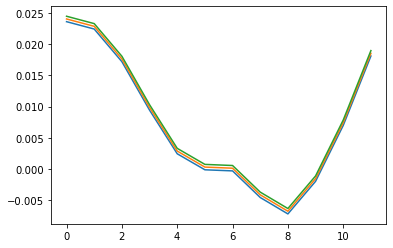

In [68]:
plt.plot(np.transpose(SOB_tst[0,60, 10:13,:]))


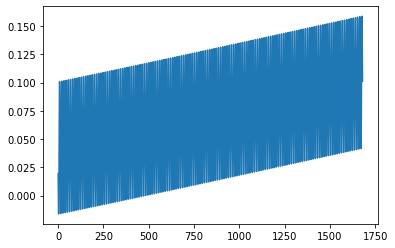

In [108]:
#plt.plot(SOB_tst[:,70,0])
plt.plot(SOB_dh[330,110,:])

In [58]:
#u_bak = np.mean(u_bak,3)

In [23]:
#u_ctl = 

# does this work? 
u_ctl = Natl['u4dmeaninterp']
u_bak = u_ctl # switch to Natl / Indp depending on what was loaded
u_ctl = np.mean(np.mean(u_ctl[:,:,0:17,:],3),2) # top 18 grid cells... 

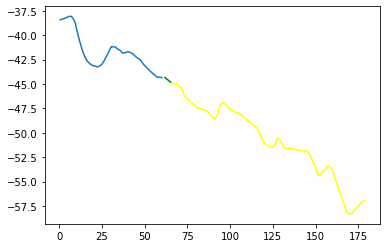

In [25]:
alim=157
tlim = 55
pts = 4

orsi1 = xr.open_dataset('Orsi_Fronts.nc')
orsiSAFx = orsi1.xsaf
orsiSAFy = orsi1.ysaf
#plt.plot(orsiSAFx,orsiSAFy)
orsiSTFx = orsi1.xstf
orsiSTFy = orsi1.ystf

plt.plot(orsiSTFx[0:tlim],orsiSTFy[0:tlim])

y1 = orsiSTFy[tlim-1].values
y2 = orsiSAFy[alim+1].values
x1 = orsiSTFx[tlim].values
x2 = orsiSAFx[alim].values
fill = np.arange(pts)/4
fillx = x1+ fill*(x2-x1)
filly = y1+ fill*(y2-y1)
plt.plot(fillx,filly, 'green')
plt.plot(orsiSAFx[alim:380], orsiSAFy[alim:380], color = 'yellow')

SJFx = np.concatenate((orsiSTFx[0:tlim], fillx, orsiSAFx[alim:380]))
SJFy = np.concatenate((orsiSTFy[0:tlim], filly, orsiSAFy[alim:380]))

In [71]:
# distraction of doing streamfunctions real quick. 
# call Antarctica 0? I think this is fine. 
# then basically add up background u from the bottom... should be decent, and cumsum. 

u_bak.shape

(360, 161, 50)

In [30]:
dz = np.diff(np.concatenate([[0],dep_natl]))

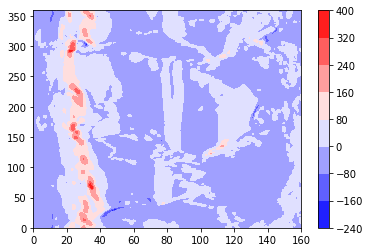

In [88]:
plt.contourf(uz)
plt.colorbar()

In [31]:
udz = u_bak*dz
uz = np.nansum(udz,2)

ValueError: operands could not be broadcast together with shapes (360,161,50,12) (50,) 

In [84]:
psi1 = np.cumsum(uz,1)

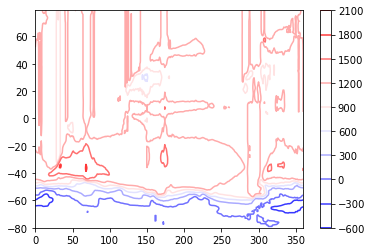

In [93]:
plt.contour(lon_natl[qlon],lat_natl[qlat],np.transpose(psi1[:,0:-1]))
plt.colorbar()

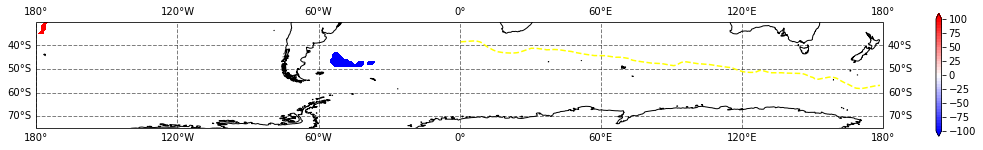

In [33]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
qlon = np.arange(0,360)
qlat = np.arange(0,160)
qlev = np.arange(0,35)
vm = 100
yr = 20

lon_natl[0]=0.3

fig.tight_layout()
#hovr = np.arange(20,160)
#
#
### setup the "umax" channel that the hovmuller follows. 
#umax = 40 - (hovr-20)/100*10#np.nanargmax(u_ctl[hovr,0:60], 1) # max u in southern ocean
#umax[52:75]=umax[52:75]-6


#
tmp = NAtl_TOHC[yr, qlat,:]
#tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 
#tmp = SOB_tst[yr, qlat, :] - SOB_tst[yr-1, qlat, :] 
#tmp = SOB_tst[yr,qlat, :]
#tmp = NAtime_dh[yr, qlat, :]
tmpu = np.transpose(u_ctl[:,qlat])
plt.set_cmap('bwr')
#plt.set_cmap('YlOrBr')#("Oranges")
levels = np.linspace(-vm, vm, 41)

Q = plt.contourf( lon_natl[qlon],lat_natl[qlat], 100*tmp[:,qlon],levels=levels, extend='both', vmin = -vm, vmax= vm,
          transform=ccrs.PlateCarree())
#plt.contour(lon_natl[qlon],lat_natl[qlat], tmpu[:,qlon], [0.1, 1], colors= 'green')
#plt.plot(hovr,umax-80 ,'yellow')
plt.plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')
#plt.plot(orsiSAFx, orsiSAFy, color='teal', linestyle = 'dashed')
#plt.plot(orsiSAFx-360, orsiSAFy, color='teal', linestyle = 'dashed')
#plt.contour(lon_natl[qlon],lat_natl[qlat],np.transpose(psi1[:,0:-1]), levels = [600, 800,1000,1200,1400, 1500], colors = 'k')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
plt.ylim([-75,-30])
plt.colorbar(Q, shrink = 0.3)
#plt.savefig('SISAZ_figures/SSHmap_yr50_raw.eps', format='eps')

<ipython-input-45-477c0df05ee9>:33: RuntimeWarning: Mean of empty slice
  toPl0 = np.nanmean(NAtime_dh[yrfin:yrfin+40, qlat, :],0) # this is now at the end
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

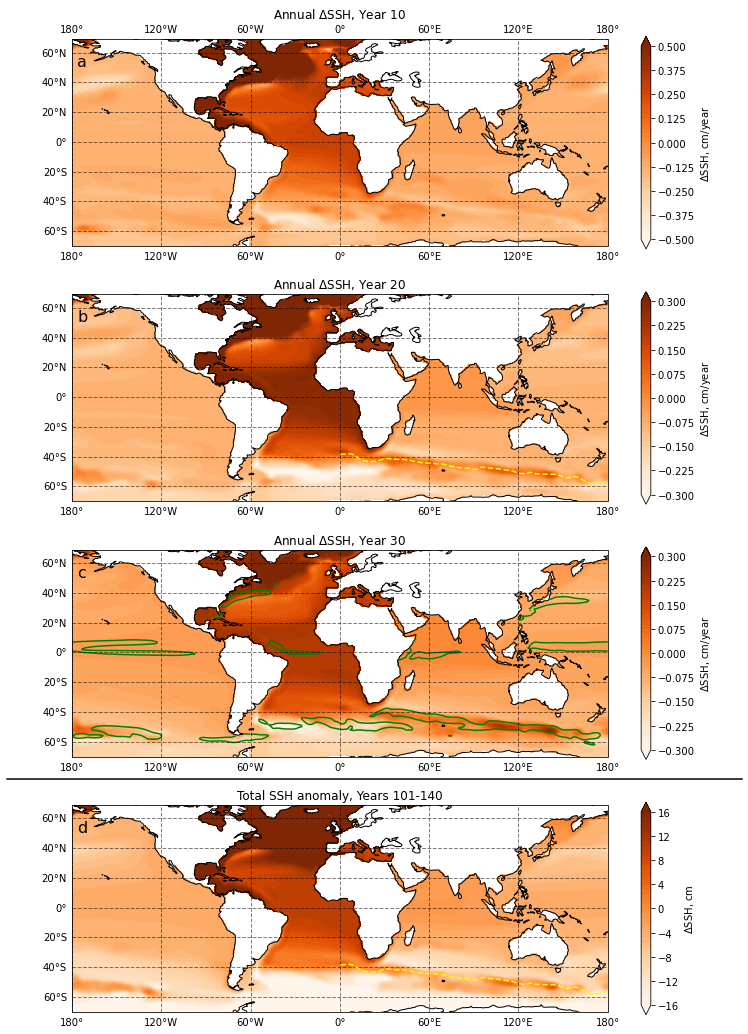

In [45]:
## Figure 5, a map of the changes driven by North Atlantic buoyancy forcing.

# Now updated to move the mean figure to the end, change colorbar, etc. 

fig, axs = plt.subplots(nrows = 4, ncols =1, figsize=(12,18),subplot_kw={'projection': ccrs.PlateCarree()})
#axs(projection=ccrs.PlateCarree())

qlon = np.arange(0,360)
qlat = np.arange(10,150)
qlev = np.arange(0,35)
vm = 16
yr = 50

lon_natl[0]=0.3

#
#tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 

yrfin = 100
yrbeg = 10
yrmid = 20
yrmid2 = 30

vmfin = 16
vmbeg = 0.5
vmmid = 0.3
vmmid2 = 0.3

# could do a trend with these... 

# 

toPl0 = np.nanmean(NAtime_dh[yrfin:yrfin+40, qlat, :],0) # this is now at the end
toPl1 = (NAtime_dh[yrbeg+2, qlat, :]  - NAtime_dh[yrbeg-2, qlat, :])/4
toPl2 = (NAtime_dh[yrmid+2, qlat, :]  - NAtime_dh[yrmid-2, qlat, :])/4
toPl3 = (NAtime_dh[yrmid2+3, qlat, :]  - NAtime_dh[yrmid2-3, qlat, :])/6
toPlu = np.transpose(u_ctl[:,qlat])

plt.set_cmap("Oranges")
# below for a dipole colorbar (e.g. bwr)
levels = np.linspace(-vm, vm, 41)
levelsbeg = np.linspace(-vmbeg, vmbeg, 41)
levelsmid = np.linspace(-vmmid, vmmid, 41)
levelsmid2 = np.linspace(-vmmid2, vmmid2, 41)

#levels = np.linspace(-vm*0.8, vm, 41)
#levelsbeg = np.linspace(-vmbeg*0.8, vmbeg, 41)
#levelsmid = np.linspace(-vmmid*0.8, vmmid, 41)
#levelsmid2 = np.linspace(-vmmid2*0.8, vmmid2, 41)

Q = axs[3].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl0[:,qlon],levels=levels, extend='both', vmin = -vmfin, vmax= vmfin,
          transform=ccrs.PlateCarree())
R = axs[0].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl1[:,qlon],levels=levelsbeg, extend='both', vmin = -vmbeg, vmax= vmbeg,
          transform=ccrs.PlateCarree())
S = axs[1].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl2[:,qlon],levels=levelsmid, extend='both', vmin = -vmmid, vmax= vmmid,
          transform=ccrs.PlateCarree())
T = axs[2].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl3[:,qlon],levels=levelsmid2, extend='both', vmin = -vmmid2, vmax= vmmid2,
          transform=ccrs.PlateCarree())
axs[2].contour(lon_natl[qlon],lat_natl[qlat], toPlu[:,qlon], [0.1, 1], colors= 'green')
#plt.plot(hovr,umax-80 ,'yellow')
axs[3].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')
axs[1].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')

import matplotlib.transforms as mtrans

#fig, axes = plt.subplots(3,2, squeeze=False)


# rearange the axes for no overlap
#fig.tight_layout()

#gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)

Qcb = plt.colorbar(Q, ax=axs[3])
Rcb = plt.colorbar(R, ax=axs[0])
Scb = plt.colorbar(S, ax=axs[1])
Tcb = plt.colorbar(T, ax=axs[2])

Qcb.set_label("$\Delta$SSH, cm",fontsize = 'medium')
Rcb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')
Scb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')
Tcb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')

axs[0].set_title('Annual $\Delta$SSH, Year 10')
axs[1].set_title('Annual $\Delta$SSH, Year 20')
axs[2].set_title('Annual $\Delta$SSH, Year 30')
axs[3].set_title('Total SSH anomaly, Years 101-140')


plabels = ['a', 'b','c','d']
for i in np.arange(0,4):
    axs[i].coastlines()
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    axs[i].text(0.01, 0.87, plabels[i], size = 16, transform = axs[i].transAxes)
    gl.right_labels = False
    if i>0:
        gl.top_labels = False
        
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
y= ys[2]-0.005
line = plt.Line2D([0.05,0.9],[y,y], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig is not working, only saving a tiny file. not sure what's up! 
#plt.savefig('SISAZ_figures/SSHmaps_7-9v2.eps') # please change filename if you make another! 

In [1]:
## Figure 5, a map of the changes driven by North Atlantic buoyancy forcing.

# slightly modified 3 panel version (no SSH map at the beginning)

fig, axs = plt.subplots(nrows = 3, ncols =1, figsize=(12,13),subplot_kw={'projection': ccrs.PlateCarree()})
#axs(projection=ccrs.PlateCarree())

qlon = np.arange(0,360)
qlat = np.arange(10,150)
qlev = np.arange(0,35)
vm = 16
yr = 50

lon_natl[0]=0.3

#hovr = np.arange(20,160)
#
#
### setup the "umax" channel that the hovmuller follows. 
#umax = 40 - (hovr-20)/100*10#np.nanargmax(u_ctl[hovr,0:60], 1) # max u in southern ocean
#umax[52:75]=umax[52:75]-6
#
#tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 

yrfin = 100
yrbeg = 10
yrmid = 20
yrmid2 = 30

vmfin = 16
vmbeg = 0.5
vmmid = 0.3
vmmid2 = 0.3

# could do a trend with these... 

# 

#toPl0 = np.nanmean(NAtime_dh[yrfin:yrfin+40, qlat, :],0)
toPl1 = (NAtime_dh[yrbeg+2, qlat, :]  - NAtime_dh[yrbeg-2, qlat, :])/4
toPl2 = (NAtime_dh[yrmid+2, qlat, :]  - NAtime_dh[yrmid-2, qlat, :])/4
toPl3 = (NAtime_dh[yrmid2+3, qlat, :]  - NAtime_dh[yrmid2-3, qlat, :])/6
toPlu = np.transpose(u_ctl[:,qlat])
plt.set_cmap("bwr")
levels = np.linspace(-vm, vm, 41)
levelsbeg = np.linspace(-vmbeg, vmbeg, 41)
levelsmid = np.linspace(-vmmid, vmmid, 41)
levelsmid2 = np.linspace(-vmmid2, vmmid2, 41)

#Q = axs[0].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl0[:,qlon],levels=levels, extend='both', vmin = -vmfin, vmax= vmfin,
#          transform=ccrs.PlateCarree())
R = axs[0].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl1[:,qlon],levels=levelsbeg, extend='both', vmin = -vmbeg, vmax= vmbeg,
          transform=ccrs.PlateCarree())
S = axs[1].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl2[:,qlon],levels=levelsmid, extend='both', vmin = -vmmid, vmax= vmmid,
          transform=ccrs.PlateCarree())
T = axs[2].contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl3[:,qlon],levels=levelsmid2, extend='both', vmin = -vmmid2, vmax= vmmid2,
          transform=ccrs.PlateCarree())
axs[2].contour(lon_natl[qlon],lat_natl[qlat], toPlu[:,qlon], [0.1, 1], colors= 'green')
#plt.plot(hovr,umax-80 ,'yellow')
axs[0].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')
axs[1].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')
#gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)

#Qcb = plt.colorbar(Q, ax=axs[0])
Rcb = plt.colorbar(R, ax=axs[0])
Scb = plt.colorbar(S, ax=axs[1])
Tcb = plt.colorbar(T, ax=axs[2])

#Qcb.set_label("$\Delta$SSH, cm",fontsize = 'medium')
Rcb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')
Scb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')
Tcb.set_label("$\Delta$SSH, cm/year",fontsize = 'medium')

plabels = ['a', 'b','c','d']
for i in np.arange(0,3):
    axs[i].coastlines()
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    axs[i].text(0.01, 0.87, plabels[i], size = 16, transform = axs[i].transAxes)
    gl.right_labels = False
    if i>0:
        gl.top_labels = False
        

# plt.savefig('SISAZ_figures/SSHmaps_3panel_5-9.eps', format='eps') # please change filename if you make another! 

NameError: name 'plt' is not defined

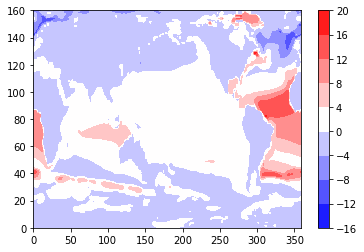

In [213]:
plt.contourf(NAtl_TOHCd[40,:,:])
plt.colorbar()

In [228]:
## trying to make a hovmuller plot that I like! This is cool. 

hovr = np.arange(0, 180)
# going to use the maximum value of u at each longitude. 

umax = 55 + 0*hovr#40 - (hovr-20)/100*10#np.nanargmax(u_ctl[hovr,0:60], 1) # max u in southern ocean
hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave. 

# now I need to iterate through each year. 
hov = np.zeros([139,hovl]) # 155 is arbitrary length of segment. 
for i in np.arange(hovl):
    #hov[:,i] = SOB_tst[:,int(umax[i]), hovr[i]]
    hov[:,i] = NAtl_TOHCd[:,int(umax[i]), hovr[i]]
#NAtime_dh[yr, qlat, :]




In [284]:
u_ctl = Natl['u4dmeaninterp']
u_bak = u_ctl # switch to Natl / Indp depending on what was loaded
u_ctl28 = np.mean(np.mean(u_ctl[:,:,0:28,:],3),2) # top 18 grid cells... 
u_ctl18 = np.mean(np.mean(u_ctl[:,:,0:18,:],3),2) 
u_ctl = u_ctl28

In [ ]:
vm = 0.1
years = 140
plt.contourf(lon_natl[hovr], np.arange(0,years), hov[0:years,:], vmin = -vm, vmax = vm, levels=20)
#plt.plot(lon_natl[hovr], np.argmin(hov[0:60,],0),  'yellow')
plt.colorbar()

In [230]:
## remaking one that follows the ARC-SAF ... probably it's been done? 

hovr = np.arange(0, 180)
hovl = len(hovr)

SJFyq=np.interp(hovr,SJFx,SJFy)
# now I need to iterate through each year. 
# calculate for entire timeseries
hov = np.zeros([139,hovl])  
for i in np.arange(hovl):
    #hov[:,i] = SOB_tst[:,int(SJFyq[i])+80, hovr[i]]
    hov[:,i] = NAtl_TOHCd28[:,int(umax[i]), hovr[i]]


In [287]:
hovr = np.arange(0, 180)
hovl = len(hovr)

SJFyq=np.interp(hovr,SJFx,SJFy)
# now I need to iterate through each year. 
# calculate for entire timeseries
hov = np.zeros([139,hovl])
uA = np.zeros([hovl,1])
uA2 = np.zeros([hovl,1])
for i in np.arange(hovl):
    #hov[:,i] = SOB_tst[:,int(SJFyq[i])+80, hovr[i]]
    #hov[:,i] = NAtl_TOHCd28[:,30, hovr[i]]
    hov[:,i] = NAtl_TOHCd28[:,int(SJFyq[i])+80, hovr[i]]
    uA[i] = u_ctl18[ hovr[i],int(SJFyq[i])+80,]
    uA2[i] = u_ctl28[ hovr[i],int(SJFyq[i])+80,]

In [313]:
# I really want to make a line with the speed of travel, say 5 cm/s ... this is reasonable ... 
# so then how would that progress along this front? 
# I'd like it to be basically done! 

# what I want is basically a time of how long it takes something going 5cm to progress along this path. 
t = 0*hovr
t = np.cumsum(111000*np.cos((SJFyq+80)*np.pi/180) *100/(7*3600*24*365))
tu = np.cumsum(111000*np.cos((SJFyq+80)*np.pi/180)/(uA.T*3600*24*365))
#tud = 111000*np.cos((SJFyq+80)*np.pi/180)/(uA.T*3600*24*365)

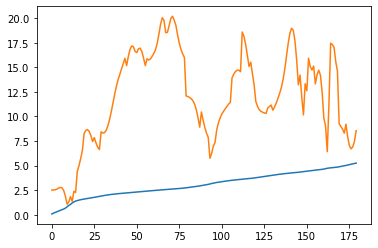

In [322]:
plt.plot(tu)
plt.plot(100*uA2)
#plt.plot(tu)


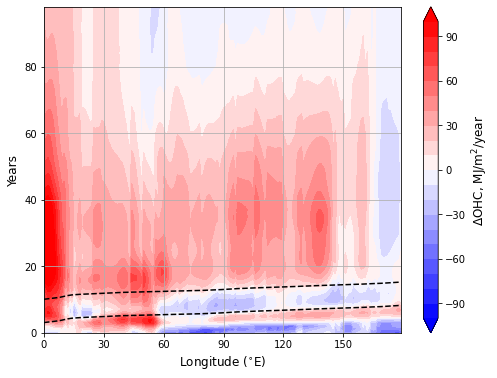

In [331]:
# so what happens if I look at the change versus the previous one? Basically, diff in time. 
plt.figure(figsize = (8,6))
years = 100
#hovd = np.diff(hov,1,0)
#vm =100
plt.set_cmap('bwr')#cmaps.cmp_b2r)
hovlev = np.linspace(-100, 100, 21)
plt.contourf(hovr, np.arange(0,years-1), 3850*1035*1e-6*hov[0:years-1,:], levels = hovlev, extend = 'both')
plt.xticks(np.arange(0,210,30))
plt.xlabel('Longitude ($^{\circ}$E)',fontsize= 'large')
plt.grid()
plt.ylabel('Years', fontsize= 'large')
Ab = plt.colorbar()
plt.plot(tu+3, 'k--')
plt.plot(tu+10, 'k--')
Ab.set_label("$\Delta$OHC, MJ/m$^2$/year",fontsize = 'large')
plt.savefig('SISAZ_figures/Hov_ARCSAF_OHC_dashedUA.eps', format = 'eps')

# question is whether to include u velocity at these points?
# or include slanted lines indicating the rate of mean advection...
# already have code for that.
# could stretch the first 20 years? 
# or somehow along-front velocity, could do? , wh

In [ ]:
plt.plot(SJFyq)

In [ ]:
## comparison plot across equatorial atlantic (much faster though)
hovr = np.arange(310,360)

# going to use the maximum value of u at each longitude. 
umax = 80
hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave. 

# now I need to iterate through each year. 
hoveq = np.zeros([140,hovl]) # 155 is arbitrary length of segment. 
for i in np.arange(hovl):
    hoveq[:,i] = NAtime_dh[:,umax, hovr[i]]
#NAtime_dh[yr, qlat, :]

In [ ]:
hovd = np.diff(hoveq,1,0)
vm =0.005
plt.contourf(lon_natl[hovr], np.arange(0,20), hovd[0:20,:], vmin = -vm, vmax = vm, levels=20)
plt.grid()

In [ ]:
## Now looking at the depth structure should be interesting! 

# what do I really care about? Well definitely it's interesting to look at patterns, say at year 35. 
# it could also be nice to set up the averaging, which is very clean. 

NAtime_U.shape

In [ ]:
climaU_natl.shape

In [ ]:
fig, axs = plt.subplots(1)

qlon = range(76,78)
qlat = range(20,70)
qlev = range(0,40)
qyr = [34,35]


ctl = np.nanmean(climaU_natl[qlon,:,:], 0)
ctl = ctl[qlat,:]
ctl = ctl[:,qlev]
vm = 0.003

toPl = np.nanmean(NAtime_U[qyr,:,:,:],0) 
toPl = np.nanmean(toPl[:,:,qlon],-1) 
toPl = toPl[qlev,:]
toPl2 = toPl[:,qlat]
toPl2 = toPl2.transpose()


# I don't feel fantastic about these, but they might give some insight ... 
# I'm not convinced that the two are totally aligned. The possibility that it's off by 5 degrees, or a small amount of 
# longitude, is worrisome. 

# hmm I'm worried my signal is nonsense, that somehow it looks nice smoothed. 
# more likely there's variability that I'm seeing, but the general pattern is legit. I'm confused at the moment. 
# yeah that's quite sad if this is the case. I'm confused though. I'm wondering whats up ... 

# it looks almost exactly like the two velocity patterns are offset by about 5 degrees in latitude, no almost 10 degrees. 
# why is this? The code is definitely wrong somehow. 

# did I resolve this? I think so but not sure .... 

axs.contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=20, colors= 'black')
# #axs[1].contour(lat_natl[qlat], - dep_natl[qlev], np.transpose(ctl[:, qlev]), levels=30, colors= 'black')
A = axs.contourf(lat_natl[qlat], - dep_natl[qlev], np.transpose(toPl2[:, qlev]), vmin = -vm, vmax = vm, levels=30)

In [ ]:
toPl.shape

In [ ]:
plt.contourf(climaU_natl[:,:,0].transpose())

In [ ]:
plt.contourf(NAtime_U[65,0,:,:], vmin = -0.05, vmax = 0.05, levels= 200)


In [ ]:
np.sin(np.pi*50/180)

In [ ]:
140*111000*np.sin(np.pi*50/180)/(0.07*3600*24*365)

In [ ]:
## Getting the T for the AMOC evolution. 

#import h5py
#
#filepath = '/nfs/data/OGCM/globalwarmingssssstnorthatlanticexpyearly1to150diff.mat'
#arrays = {}
#f = h5py.File(filepath)
#for k, v in f.items():
#    arrays[k] = np.array(v)

#NAtime_T = np.squeeze(arrays['temp4dmeanwarminginterpdiff'])
#np.save('/nfs/data/OGCM/ssssstnorthatlantic_T150diff.npy', NAtime_T)

In [12]:
# Now just load that, makes things a little quicker. 
NAtime_T = np.load('/nfs/data/OGCM/ssssstnorthatlantic_T150diff.npy')

## OHC evolution (not just SSH) 

In [143]:
levh = np.diff(np.concatenate((np.array([0]),dep_natl)))
#asdf=toPl * levh
#OHCip = np.nansum(asdf,1)

levh2 = 1*levh
levh2[22:50] = 0
#asdf2=toPl * levh2
#OHCip2 = np.nansum(asdf2,1)
#plt.plot(lat_natl[qlat],OHCip)
#plt.plot(lat_natl[qlat],OHCip2)

In [144]:
NAtl_Tdz = NAtime_T.transpose([0,2,3,1])*levh2

In [145]:
NAtl_TOHC= np.nansum(NAtl_Tdz, 3)

In [146]:
NAtl_TOHCd = np.diff(NAtl_TOHC,axis=0)

In [47]:
NAtl_TOHCd.shape

(139, 161, 360)

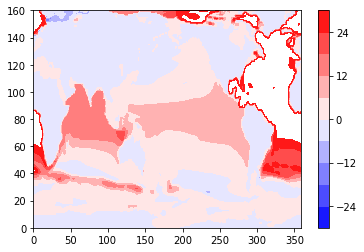

In [125]:
plt.contourf(NAtl_TOHCd36[30,:,:], levels=3*np.linspace(-10,10,11))
plt.colorbar()

In [138]:
NAtl_TOHCd28 = NAtl_TOHCd
NAtl_TOHC28 = NAtl_TOHC

In [141]:
dep_natl[22]
# 36 is pretty good. Upper 2000m shows similar signal to SSH. ARCSAF stands out but isn't a stronger signal than the tropical Indian. 
# I'm really curious what upper 1000 looks like! Honestly not super different! That's interesting! 

513.26

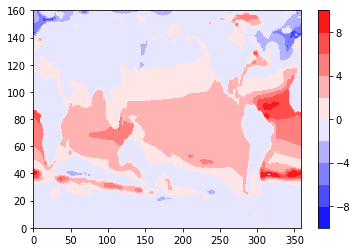

In [175]:
plt.contourf(NAtl_TOHCd[53,:,:], levels=1*np.linspace(-10,10,11))
plt.colorbar()

In [201]:
#np.where(NAtl_TOHC28 == 0, np.nan, NAtl_TOHC28)

In [199]:
toPl0 = np.nanmean(NAtl_TOHC28[yrfin:yrfin+40, qlat, :],0)*3850*1035/1e9 # this is now at the end
#toPl1 = (NAtime_dh[yrbeg+2, qlat, :]  - NAtime_dh[yrbeg-2, qlat, :])/4
#toPl2 = (NAtime_dh[yrmid+2, qlat, :]  - NAtime_dh[yrmid-2, qlat, :])/4
#toPl3 = (NAtime_dh[yrmid2+3, qlat, :]  - NAtime_dh[yrmid2-3, qlat, :])/6
#toPl1 = np.nanmean(NAtl_TOHCd[yrbeg-2:yrbeg+2, qlat, :],0)*3850*1035/1e6
#toPl2 = np.nanmean(NAtl_TOHCd[yrmid-2:yrmid+2, qlat, :],0)*3850*1035/1e6
#toPl3 = np.nanmean(NAtl_TOHCd[yrmid2-2:yrmid2+2, qlat, :],0)*3850*1035/1e6
#
toPl1 = np.nanmean(NAtl_TOHCd28[yrbeg:yrbeg+1, qlat, :],0)*3850*1035/1e6
toPl2 = np.nanmean(NAtl_TOHCd28[yrmid:yrmid+1, qlat, :],0)*3850*1035/1e6
toPl3 = np.nanmean(NAtl_TOHCd28[yrmid2:yrmid2+1,qlat,:],0)*3850*1035/1e6


toPl0 = np.where(toPl0 == 0, np.nan, toPl0)
toPl1 = np.where(toPl1 == 0, np.nan, toPl1)
toPl2 = np.where(toPl2 == 0, np.nan, toPl2)
toPl3 = np.where(toPl3 == 0, np.nan, toPl3)

In [178]:
import colormaps as cmaps

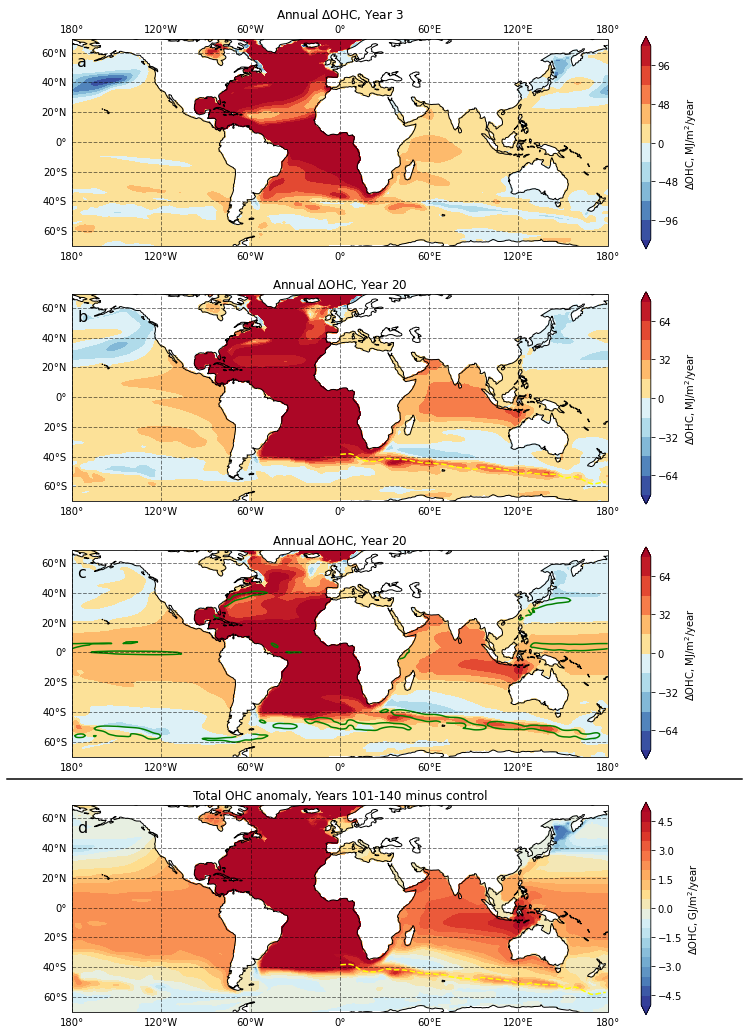

In [333]:
## Figure 9, a map of the changes driven by North Atlantic buoyancy forcing.

# Now we are using OHC not SSH!


fig, axs = plt.subplots(nrows = 4, ncols =1, figsize=(12,18),subplot_kw={'projection': ccrs.PlateCarree()})
#axs(projection=ccrs.PlateCarree())

qlon = np.arange(0,360)
qlat = np.arange(10,150)
qlev = np.arange(0,35)

yr = 50

lon_natl[0]=0.3

#
#tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 

yrfin = 100
yrbeg = 3
yrmid = 20
yrmid2 = 20
## these are for upper 500m (i.e. 22)
vmfin = 3 # about 3
vmbeg = 60#15 # 60
vmmid = 40#10 
vmmid2 = 40#10

vmfin = 5 # about 3
vmbeg = 120#15 # 60
vmmid = 80#10 
vmmid2 = 80#10

# could do a trend with these... 

# 
#using these but computed above!
#toPl0 = np.nanmean(NAtl_TOHC[yrfin:yrfin+40, qlat, :],0) # this is now at the end
#toPl1 = np.nanmean(NAtl_TOHCd[yrbeg-2:yrbeg+2, qlat, :],0)
#toPl2 = np.nanmean(NAtl_TOHCd[yrmid-2:yrmid+2, qlat, :],0)
#toPl3 = np.nanmean(NAtl_TOHCd[yrmid2-2:yrmid2+2, qlat, :],0)

#toPl1 = (NAtime_dh[yrbeg+2, qlat, :]  - NAtime_dh[yrbeg-2, qlat, :])/4
#toPl2 = (NAtime_dh[yrmid+2, qlat, :]  - NAtime_dh[yrmid-2, qlat, :])/4
#toPl3 = (NAtime_dh[yrmid2+3, qlat, :]  - NAtime_dh[yrmid2-3, qlat, :])/6


toPlu = np.transpose(u_ctl[:,qlat])

#plt.set_cmap("Oranges")
plt.set_cmap(cmaps.cmp_b2r)
# below for a dipole colorbar (e.g. bwr)
levels = np.linspace(-vmfin, vmfin, 21)
levelsbeg = np.linspace(-vmbeg, vmbeg, 11)
levelsmid = np.linspace(-vmmid, vmmid, 11)
levelsmid2 = np.linspace(-vmmid2, vmmid2, 11)

#levels = np.linspace(-vm*0.8, vm, 41)
#levelsbeg = np.linspace(-vmbeg*0.8, vmbeg, 41)
#levelsmid = np.linspace(-vmmid*0.8, vmmid, 41)
#levelsmid2 = np.linspace(-vmmid2*0.8, vmmid2, 41)

Q = axs[3].contourf( lon_natl[qlon],lat_natl[qlat], toPl0[:,qlon],levels=levels, extend='both', vmin = -vmfin, vmax= vmfin,
          transform=ccrs.PlateCarree())
R = axs[0].contourf( lon_natl[qlon],lat_natl[qlat], toPl1[:,qlon],levels=levelsbeg, extend='both', vmin = -vmbeg, vmax= vmbeg,
          transform=ccrs.PlateCarree())
S = axs[1].contourf( lon_natl[qlon],lat_natl[qlat], toPl2[:,qlon],levels=levelsmid, extend='both', vmin = -vmmid, vmax= vmmid,
          transform=ccrs.PlateCarree())
T = axs[2].contourf( lon_natl[qlon],lat_natl[qlat], toPl3[:,qlon],levels=levelsmid2, extend='both', vmin = -vmmid2, vmax= vmmid2,
          transform=ccrs.PlateCarree())
axs[2].contour(lon_natl[qlon],lat_natl[qlat], toPlu[:,qlon], [0.1, 1], colors= 'green')
#plt.plot(hovr,umax-80 ,'yellow')
axs[3].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')
axs[1].plot(SJFx, SJFy, color='yellow', linestyle = 'dashed')

import matplotlib.transforms as mtrans

#fig, axes = plt.subplots(3,2, squeeze=False)


# rearange the axes for no overlap
#fig.tight_layout()

#gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)

Qcb = plt.colorbar(Q, ax=axs[3])
Rcb = plt.colorbar(R, ax=axs[0])
Scb = plt.colorbar(S, ax=axs[1])
Tcb = plt.colorbar(T, ax=axs[2])

Qcb.set_label("$\Delta$OHC, GJ/m$^2$/year",fontsize = 'medium')
Rcb.set_label("$\Delta$OHC, MJ/m$^2$/year",fontsize = 'medium')
Scb.set_label("$\Delta$OHC, MJ/m$^2$/year",fontsize = 'medium')
Tcb.set_label("$\Delta$OHC, MJ/m$^2$/year",fontsize = 'medium')

axs[0].set_title('Annual $\Delta$OHC, Year 3')
axs[1].set_title('Annual $\Delta$OHC, Year 20')
axs[2].set_title('Annual $\Delta$OHC, Year 20')
axs[3].set_title('Total OHC anomaly, Years 101-140 minus control')


plabels = ['a', 'b','c','d']
for i in np.arange(0,4):
    axs[i].coastlines()
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    axs[i].text(0.01, 0.87, plabels[i], size = 16, transform = axs[i].transAxes)
    gl.right_labels = False
    if i>0:
        gl.top_labels = False
        
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
y= ys[2]-0.005
line = plt.Line2D([0.05,0.9],[y,y], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig is not working, only saving a tiny file. not sure what's up! 
#plt.savefig('SISAZ_figures/OHCmaps_2-27v2.eps') # please change filename if you make another! 

## quick look at time evolution of temperature in subsurface Atlantic.

In [13]:
NAtime_T.shape


(140, 50, 161, 360)

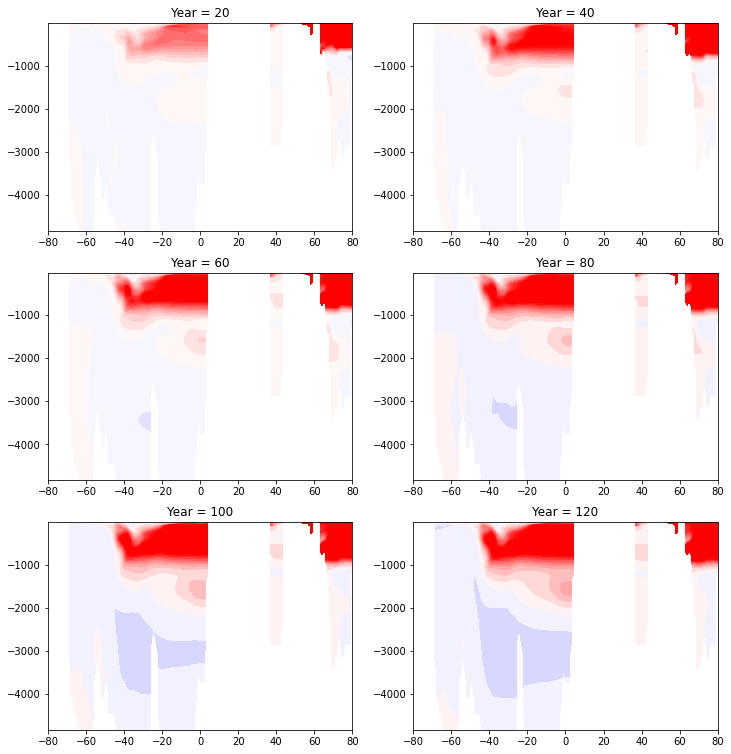

In [118]:
# what I want is multiple section of the atlantic. 

fig, axs = plt.subplots(nrows = 3, ncols =2, figsize=(12,13))
plt.set_cmap('bwr')

yrs = [5, 10, 15, 20, 25, 30]
for i in range(6):
    myyr = yrs[i]*4
    axs[int(i/2),i%2].contourf( lat_natl, -dep_natl[:-3], NAtime_T[myyr, 0:-3, :, 5], levels = 60, vmin= -2, vmax = 2) 
    axs[int(i/2),i%2].set_title("Year = " + str(myyr))

In [ ]:
# what I want is multiple section of the atlantic. 

fig, axs = plt.subplots(nrows = 3, ncols =2, figsize=(12,13))
plt.set_cmap('bwr')

yrs = [5, 10, 15, 20, 25, 30]

for i in range(6):
    myyr = yrs[i] *4
    axs[int(i/2),i%2].contourf( lat_natl, -dep_natl, NAtime_T[myyr, :, :, 70], levels = 20, vmin= -2, vmax = 2) 
    axs[int(i/2),i%2].set_title("Year = " + str(myyr))


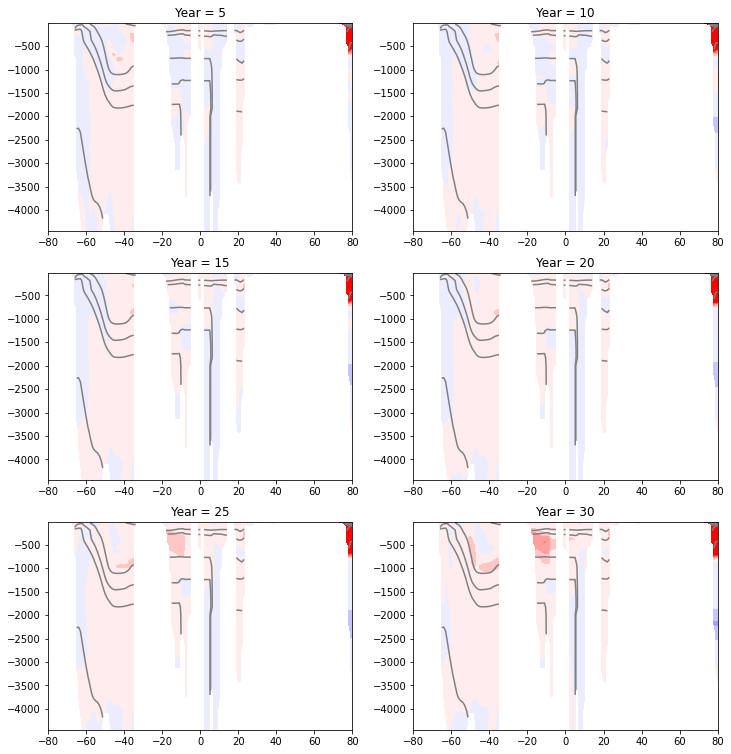

In [122]:
# what I want is multiple section of the atlantic. 
# I also want to overlay isopycnals. 
fig, axs = plt.subplots(nrows = 3, ncols =2, figsize=(12,13))
plt.set_cmap('bwr')

yrs = [5, 10, 15, 20, 25, 30]
asdf = climsig0_natl.transpose()
mylon = 120

for i in range(6):
    myyr = yrs[i] *1
    axs[int(i/2),i%2].contourf( lat_natl, -dep_natl[0:-4], NAtime_T[myyr, 0:-4, :, mylon], levels = 60, vmin= -1, vmax = 1) 
    axs[int(i/2),i%2].set_title("Year = " + str(myyr))
    axs[int(i/2),i%2].contour( lat_natl, -dep_natl[0:-4], asdf[0:-4,:,mylon], colors = 'gray', levels = [25, 26, 27, 27.3, 27.5, 27.7, 27.9])


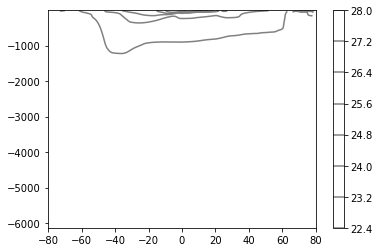

In [50]:
plt.contour( lat_natl, -dep_natl, asdf[:,:,mylon], colors = 'gray')
plt.colorbar()

In [ ]:
#NAtime_T.shape

# here I'm working out how to do the thing. 

## Timeseries analysis with monthly SSH data



In [3]:
## first let's import the monthly data.
# Probably the main goal would just be to get a hovmuller plot. 
# but also a movie could be nice.
# need these to get background u. 
import scipy.io as sio
#Natl=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstnorthatlanticexplast40years.mat')
Indp=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstindpacexplast40years.mat')


In [ ]:
u_cont = Indp['u4dmeaninterp']
u_cont = np.mean(u_cont,3)

In [ ]:
## First let's do a Hovmuller along the region that I care about?
u_cont.shape

In [ ]:
# loading the dataset I want to use. 
import mat73 
SSHmon = mat73.loadmat('/home/bataylor/SSHrunclimhfluxcmip6ssssstnorthatlantic.mat')
#pa = Natl['trac4dmeaninterp']

In [ ]:
SSHmo = SSHmon['sealevelmeanwarminginterpalldiff']

SSHmo.shape

In [ ]:
# monthly hovmuller along the channel

hovr = np.arange(40,110)
#
#
### setup the "umax" channel that the hovmuller follows. 
umax = 30 - 0*(hovr-20)/100*10 # latitude 

hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave. 

nyr = 20 
hov = np.zeros([12*nyr,hovl]) # 155 is arbitrary length of segment. 
for i in np.arange(hovl):
    hov[:,i] = SSHmo[hovr[i], int(umax[i]), np.arange(0,12*nyr) ]
#NAtime_dh[yr, qlat, :]

## sample u here. 
uchan = np.zeros([hovl,1])
u_cont_up = np.mean(u_cont[:,:,1:20],2)

for i in np.arange(hovl):
    uchan[i] = u_cont_up[hovr[i], int(umax[i])]
    
    
nbg= 10
nyr=20
yrlen = nyr - nbg

hov = hov[12*nbg:12*nyr, :]
fix1 = np.nanmean(hov,0) # this is removing the background spatial pattern
hov = hov - np.tile(fix1, [yrlen*12,1])
fix2 = np.nanmean(hov,1)
hov = hov - np.transpose(np.tile(fix2, [hovl,1]))

In [ ]:
#plt.figure(figsize=(12,12))
#plt.contourf(hov, levels=50)

In [ ]:
hov.shape

In [ ]:
# take a velocity of 10 cm/s, or 0.1 m/s. 
# this would go in a day about 0.36*24 km, or 8.6 ish km 
# then it's like ~ 86 km in a degree at this latitude, very roughly, so that's 10 days per degree. 
# then you'd get around 35 degrees in a year.
1/0.04 *111000*np.cos((-80+umax[0])/180 * np.pi)/(86400*365)

# the propagation speed is something like 2.5 cm/s in that region that's clearly propagating... 
# it's much slower 
# Or as large as 6.4 cm/s in some other areas...

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex = True, figsize=(12,12),gridspec_kw={'height_ratios': [1, 3]},constrained_layout=True)

plt.set_cmap('bwr')
lon_natl = SSHmon['loninterp']


axs[0].plot(lon_natl[hovr], uchan)

hovd = np.diff(hov,1,0)
vm =0.005
M = axs[1].contourf(lon_natl[hovr], np.arange(nbg,nyr-1,1/12), hov[0:-12,:], vmin = -vm, vmax = vm, levels=60)
plt.grid()
plt.sharex = True
plt.colorbar(M)

myl = 10
for i in np.arange(15,hovl,10):
    myl = i
    myv = uchan[myl]
    sl = 1/myv *111000*np.cos((-80+umax[0])/180 * np.pi)/(86400*365)   # slope in years/degree longitude!
    myra = np.arange(-3,+3)
    axs[1].plot(lon_natl[hovr[myl+myra]], 15+sl*myra, 'k')
# 50 S    
#axs[1].plot(lon_natl[hovr[10+myra]], 16.5+0.08*myra)
#axs[1].plot(lon_natl[hovr[110+myra]], 16.75+0.035*myra)

# 20 S
#axs[1].plot(lon_natl[hovr[60+myra]], 16.5-0.033*myra)

# 30 S
#axs[1].plot(lon_natl[hovr[30+myra]], 16.5-0.04*myra)

In [ ]:
# obviously this is an annual cycle, and the propagation of the annual cycle does not say a whole lot about Rossby waves ... 
# So I could remove the annual cycle, and maybe that would tell me more... 

# Or I can try to look at another region, where I don't think Rossby waves are propagating eastward, and see what that's like.
# In these other regions without the wavetrain, variability is very flat. occasionally westward propagation. 
# there is a very distinctive difference across areas; this is good, and means I'm onto something ... 

# This is definitely interesting. Does the annual cycle force Rossby waves (I mean it must?) 
# Probably I should remove them. could look at the Killworth paper that discusses this? 

# sure Ok, I think this is pretty neat. I suspect that regions with faster rates of propagation
# as estimated from the slope of this cycle would be areas with faster u, if I sample U along here? 
# That would be super interesting, maybe that's the first order thing. 
# Then second would be to not be lazy and simply. 

# yeah we don't want to remove the annual signal because that is the main signal, cool. 
# but we can remove basically the mean. 

# a neat figure would be to summarize this in one map, showing where there is significant eastward propagation in the model. 
# Could just consider where it's local within the last few. 

In [ ]:


alim=157
tlim = 55
pts = 4

orsi1 = xr.open_dataset('Orsi_Fronts.nc')
orsiSAFx = orsi1.xsaf
orsiSAFy = orsi1.ysaf
#plt.plot(orsiSAFx,orsiSAFy)
orsiSTFx = orsi1.xstf
orsiSTFy = orsi1.ystf

plt.plot(orsiSTFx[0:tlim],orsiSTFy[0:tlim])

y1 = orsiSTFy[tlim-1].values
y2 = orsiSAFy[alim+1].values
x1 = orsiSTFx[tlim].values
x2 = orsiSAFx[alim].values
fill = np.arange(pts)/4
fillx = x1+ fill*(x2-x1)
filly = y1+ fill*(y2-y1)
plt.plot(fillx,filly, 'green')
plt.plot(orsiSAFx[alim:380], orsiSAFy[alim:380], color = 'yellow')

SJFx = np.concatenate((orsiSTFx[0:tlim], fillx, orsiSAFx[alim:380]))
SJFy = np.concatenate((orsiSTFy[0:tlim], filly, orsiSAFy[alim:380]))

In [ ]:
# monthly hovmuller along the ARC-SAF

hovr = np.arange(30,165)

ARCSAFy=np.interp(hovr+0.5,SJFx,SJFy) 

#
#
### setup the "umax" channel that the hovmuller follows. 
#umax =40 - 1*(hovr-20)/100*10 # latitude 

hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave. 

nbg= 30
nyr= 40
yrlen = nyr - nbg
hov = np.zeros([12*nyr,hovl]) # 155 is arbitrary length of segment. 
for i in np.arange(hovl):
    hov[:,i] = SSHmo[hovr[i], int(ARCSAFy[i])+80, np.arange(0,12*nyr) ]
#NAtime_dh[yr, qlat, :]

## sample u here. 
uchan = np.zeros([hovl,1])
u_cont_up = np.mean(u_cont[:,:,1:20],2)

for i in np.arange(hovl):
    uchan[i] = u_cont_up[hovr[i], int(ARCSAFy[i])+80]
    
    


hov = hov[12*nbg:12*nyr, :]
fix1 = np.nanmean(hov,0) # this is removing the background spatial pattern
hov = hov - np.tile(fix1, [yrlen*12,1])
#fix2 = np.nanmean(hov,1)
#hov = hov - np.transpose(np.tile(fix2, [hovl,1]))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex = True, figsize=(12,12),gridspec_kw={'height_ratios': [1, 3]},constrained_layout=True)

plt.set_cmap('bwr')
lon_natl = SSHmon['loninterp']


axs[0].plot(lon_natl[hovr], uchan)

hovd = np.diff(hov,1,0)
vm =0.002
M = axs[1].contourf(lon_natl[hovr], np.arange(nbg,nyr-1,1/12), hovd[0:-11,:], vmin = -vm, vmax = vm, levels=30)
plt.grid()
plt.sharex = True
plt.colorbar(M)




In [ ]:
## trying to get rid of annual cycle somehow ... can we make progress? 

# I want to see how the buoyancy signal, which is not annually repeating, propagates ... 
# For this task, the time selection is highly relevant! 
# Basically, it could look something like the Hovmuller plots I've already created by annual averaging
# Got that part. 
# Now yeah let's take the average of every thing: make a 3D array of month, year, and longitude. 
# then take mean across all the year. 



In [ ]:
# monthly hovmuller along the channel

hovr = np.arange(20,150)
#
#
### setup the "umax" channel that the hovmuller follows. 
umax = 30 - 0*(hovr-20)/100*10 # latitude 

hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave. 

    
nbg= 35
nyr=45
yrlen = nyr - nbg
hov = np.zeros([12*nyr,hovl]) # 155 is arbitrary length of segment. 
for i in np.arange(hovl):
    hov[:,i] = SSHmo[hovr[i], int(umax[i]), np.arange(0,12*nyr) ]
#NAtime_dh[yr, qlat, :]

## sample u here. 
uchan = np.zeros([hovl,1])
u_cont_up = np.mean(u_cont[:,:,1:20],2)

for i in np.arange(hovl):
    uchan[i] = u_cont_up[hovr[i], int(umax[i])]
    
    


hov = hov[12*nbg:12*nyr, :]
fix1 = np.nanmean(hov,0) # this is removing the background spatial pattern
hov = hov - np.tile(fix1, [yrlen*12,1])
#fix2 = np.nanmean(hov,1) # this is removing the average each time period... 
#hov = hov - np.transpose(np.tile(fix2, [hovl,1]))




In [ ]:
# Now let's do this remove mean annual signal thing. 
monm = np.reshape(hov, [yrlen, 12, hovl])
monm2 = np.mean(monm, 0)
#monm2.shape
monm3 = np.tile(monm2, [yrlen,1])
monm3.shape
hov = hov- monm3

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex = True, figsize=(12,12),gridspec_kw={'height_ratios': [1, 3]},constrained_layout=True)

plt.set_cmap('bwr')
lon_natl = SSHmon['loninterp']


axs[0].plot(lon_natl[hovr], uchan)

hovd = np.diff(hov,1,0)
vm =0.001
M = axs[1].contourf(lon_natl[hovr], np.arange(nbg,nyr-1,1/12), hovd[0:-11,:], vmin = -vm, vmax = vm, levels=200)
plt.grid()
plt.sharex = True
plt.colorbar(M)

myl = 10
for i in np.arange(15,hovl,10):
    myl = i
    myv = uchan[myl]
    sl = 1/myv *111000*np.cos((-80+umax[0])/180 * np.pi)/(86400*365)   # slope in years/degree longitude!
    myra = np.arange(-3,+3)
    axs[1].plot(lon_natl[hovr[myl+myra]], 35+sl*myra, 'k')
# 50 S    
#axs[1].plot(lon_natl[hovr[10+myra]], 16.5+0.08*myra)
#axs[1].plot(lon_natl[hovr[110+myra]], 16.75+0.035*myra)

# 20 S
#axs[1].plot(lon_natl[hovr[60+myra]], 16.5-0.033*myra)

# 30 S
#axs[1].plot(lon_natl[hovr[30+myra]], 16.5-0.04*myra)

In [ ]:
plt.plot(hovd[0:-24,15:120:50])

In [ ]:
# OK we have hovd.
#hovd = hovd[0:-11,:] # so it's an even multiple of 12. 
hovd_mon = np.reshape(hov, [yrlen, 12, hovl])
monmax = np.max(hovd_mon, 1)
monmin = np.min(hovd_mon, 1)
moncyc = monmax-monmin

#monm2.shape
#monm3 = np.tile(monm2, [yrlen,1])
#monm3.shape
#hov = hov- monm3

In [ ]:
plt.set_cmap('viridis')
vm = 0.003
N = plt.contourf(lon_natl[hovr], np.arange(nbg,nyr), moncyc, vmin = 0, vmax = vm, levels = 50)
plt.colorbar(N)

In [ ]:
plt.plot(hov[0:-24,15:120:50])
# what we see here is that the variations are much smaller than the overall trend. 
# it appears that increase in annual cycle might be associated with SSH increase,
# but not much! definitely not the driver in and of itself. 

In [ ]:
# map of annual increase! This should take about 5 minutes. 

ISSHmo = SSHmo[:,10:150,0:480]

hov_mon = np.reshape(ISSHmo, [360, 140, 40, 12])
monmaxf = np.max(hov_mon[:,:,15:20,:], 3)
monmaxi = np.max(hov_mon[:,:,0:5,:], 3)
monminf = np.min(hov_mon[:,:,15:20,:], 3)
monmini = np.min(hov_mon[:,:,0:5,:], 3)

#monmin = np.min(hov_mon, 3)
moncycf = np.mean(monmaxf,2) - np.mean(monminf,2)
moncyci = np.mean(monmaxi,2) - np.mean(monmini,2)


In [ ]:
plt.set_cmap('viridis')
M = plt.contourf(np.transpose(moncyci), vmin = 0, vmax = 0.02, levels=60)
plt.colorbar(M)

In [ ]:
M = plt.contourf( np.arange(0,360), np.arange(-70,70), np.transpose(moncycfd - moncycid), vmin = -0.01, vmax=0.01, levels=60)
plt.set_cmap('bwr')
plt.grid()
plt.colorbar(M)

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
qlon = np.arange(0,360)
qlat = np.arange(10,150)
qlev = np.arange(0,35)
vm = 0.01
yr = 35

lon_natl[0]=0.3

#hovr = np.arange(20,160)
#
#
### setup the "umax" channel that the hovmuller follows. 
#umax = 40 - (hovr-20)/100*10#np.nanargmax(u_ctl[hovr,0:60], 1) # max u in southern ocean
#umax[52:75]=umax[52:75]-6
#
tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 
#tmpu = np.transpose(u_ctl[:,qlat])
plt.set_cmap("bwr")

Q = plt.contourf(lon_natl[qlon], lat_natl[qlat], np.transpose(moncycfd - moncycid),levels=100, vmin = -vm, vmax= vm,
          transform=ccrs.PlateCarree())
#plt.contour(lon_natl[qlon],lat_natl[qlat], tmpu[:,qlon], [0.1, 1], colors= 'green')
#plt.plot(hovr,umax-80 ,'yellow')
#plt.plot(SJFx, SJFy, color='teal', linestyle = 'dashed')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)


plt.colorbar(Q)

This is very fascinating, somehow there's an increase in amplitude of this annual cycle as a result of this forcing perturbation. It's not really happening in other places. Might as well look at the whole globe then... 

Yes, it's definitely associated with the perturbation itself. It drives a really strong annual cycle of SSH in the forcing region ... wild... this must be because there is a really strong SSH cycle that is applied by the forcing. This is fascinating. Is this good? 

Well that cycle is felt quite far away, which is neat... I wonder what that could mean! It would probably mean that the signal is maybe interfering constructively with the local annual cycle... 

The fact that there's a strong annual cycle is quite exciting, because it potentially allows us to track down this signal. 

Honestly, I'm skeptical of this result now. I think I have a good reason: 
If there's an enormous trend, the max-min will be dominated by the trend, not by the seasonal cycle. This is why identifying the annual cycle harmonic as opposed to the trend is helpful.
The trend is indeed enormous in the first 5 years; I think after that it's a bit better, so the new maps are more realistic. 

I think it will tell us something more to detrend first, or do a fit to annual cycle (worse I think). I just need to quickly detrend this signal. This is not hard. but then I need to do a bunch else after this... 

Sure just detrend, and don't hypothesize any more. Yeah it's detrended and not much difference. I think there's a real thing happening here. I think 


Next things to do - make it a little prettier. Compare plot of mean change - similar but not identical. 
If it's an annual cycle signal being generated in the North Atlantic and propagating, that does make it nice and clear in this model ... it's very interesting. rn



In [ ]:
from scipy import signal 

ISSHmo = SSHmo[:,10:150,0:660]

ISSHmo = np.nan_to_num(ISSHmo)


yr1 = 1
yr2 = 5
yr3 = 15
yr4 = 20

samf = signal.detrend(ISSHmo[:,:,12*yr3:12*yr4])
sami = signal.detrend(ISSHmo[:,:,12*yr1:12*yr2])

monf = np.reshape(samf, [360, 140, yr4-yr3, 12])
moni = np.reshape(sami, [360, 140, yr2-yr1, 12])

monmaxf = np.max(monf, 3)
monmaxi = np.max(moni, 3)
monminf = np.min(monf, 3)
monmini = np.min(moni, 3)

#monmin = np.min(hov_mon, 3)
moncycfd = np.mean(monmaxf,2) - np.mean(monminf,2)
moncycid = np.mean(monmaxi,2) - np.mean(monmini,2)


In [ ]:
M = plt.contourf(np.arange(0,360), np.arange(-70,70),np.transpose(moncycfd - moncycid), vmin = -0.02, vmax=0.02, levels=60)
plt.set_cmap('bwr')
plt.grid()
plt.plot(hovr, umax-80)
plt.colorbar(M)

In [ ]:
plt.set_cmap('viridis')
M = plt.contourf(np.arange(0,360), np.arange(-70,70), np.transpose(moncycid), vmin = 0, vmax = 0.02, levels=60)
plt.colorbar(M)

In [ ]:
plt.set_cmap('viridis')
M = plt.contourf(np.arange(0,360), np.arange(-70,70),np.transpose(moncyci), vmin = 0, vmax = 0.02, levels=60)
plt.colorbar(M)

In [ ]:
SSHmo.shape

In [ ]:
plt.figure(figsize=[10,7])
X1 = SSHmo[300, 120, 0:500]
plt.plot(np.transpose(X1))
X5 = SSHmo[300, 90, 0:500]
plt.plot(np.transpose(X5))
X3 = SSHmo[20, 43, 0:500]
plt.plot(np.transpose(X3))
X4 = SSHmo[150, 25, 0:500]
plt.plot(np.transpose(X4))
X2 = SSHmo[200, 60, 0:500]
plt.plot(np.transpose(X2))



plt.legend(['Gulf Stream Ext','Trop Atlantic','Agulhas Retroflection','South of Tasmania','Subtropical Pacific'])

    

In [ ]:
# another hypothesis I had is that we could show which month has the largest amplitude! 

# this is cool! 

from scipy import signal 

ISSHmo = SSHmo[:,10:150,0:660]

ISSHmo = np.nan_to_num(ISSHmo)


yr1 = 12
yr2 = 15
yr3 = 3 
yr4 = 8

samf = signal.detrend(ISSHmo[:,:,12*yr3:12*yr4])
sami = signal.detrend(ISSHmo[:,:,12*yr1:12*yr2])

monf = np.reshape(samf, [360, 140, yr4-yr3, 12])
moni = np.reshape(sami, [360, 140, yr2-yr1, 12])

mondif = monf#-moni

indmaxd = np.argmax(mondif, 3)
indmaxdm = np.median(indmaxd,2)



#indmaxf = np.max(monf, 3)
#maxi = np.max(moni, 3)
#monminf = np.min(monf, 3)
#monmini = np.min(moni, 3)
#
##monmin = np.min(hov_mon, 3)
#moncycfd = np.mean(monmaxf,2) - np.mean(monminf,2)
#moncycid = np.mean(monmaxi,2) - np.mean(monmini,2)


In [ ]:
indmaxd.shape

In [ ]:


plt.figure(figsize = (12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.set_cmap('hsv')
M = plt.contourf(np.arange(0,360), np.arange(-70,60),np.transpose(indmaxdm[0:360,0:130]), 
                 vmin = 0, vmax = 11, levels=12,  transform=ccrs.PlateCarree())
plt.colorbar(M)
plt.grid()
plt.plot(SJFx,SJFy) 
#plt.contour(np.arange(0,360), np.arange(-70,60), np.transpose(moncycfd[0:360,0:130] - moncycid[0:180,0:40]), levels= [0.002, 0.013], colors= 'white')

In [ ]:

plt.figure(figsize = (12,6))
plt.set_cmap('hsv')
M = plt.contourf(np.arange(0,180), np.arange(-70,-30),np.transpose(indmaxdm[0:180,0:40]), vmin = 0, vmax = 11, levels=12)
plt.colorbar(M)
plt.grid()
plt.plot(SJFx,SJFy) 
plt.contour(np.arange(0,180), np.arange(-70,-30), np.transpose(moncycfd[0:180,0:40] - moncycid[0:180,0:40]), levels= [0.002, 0.013], colors= 'white')

In [ ]:
plt.plot(np.arange(30,160), indmaxdm[30:160,25])

In [ ]:
hovr = np.arange(30,170)
umax = 42 - (hovr-15)/100*11#np.nanargmax(u_ctl[hovr,0:60], 1) # max u in southern ocean
#hovl = len(hovr)
#umax[0:16] = 40 # just make it at 40 S to catch the wave.

In [ ]:
plt.plot(umax)

In [ ]:
hovl = len(hovr)
hovp = 0 * hovr
for i in np.arange(hovl):
    hovp[i] = indmaxdm[hovr[i], int(umax[i])-5]
    
plt.plot(hovr, hovp)

In [ ]:
plt.plot(hovr, umax-10)

In [ ]:
SSHmo.shape

In [ ]:
plt.plot(SSHmo[50,37,0:600])

## here we're going to try to generate some images to animate!

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation



#img = [] # some array of images
frames = [] # for storing the generated images

fig = plt.figure(figsize=(18,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

qlon = np.arange(0,360)
qlat = np.arange(5,160)
qlev = np.arange(0,35)
vm = 0.003

plt.set_cmap("bwr")
for i in range(6):
    yr = i+3 
    tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :] 
    #A = axs.contourf(lat_natl[qlat], - dep_natl[qlev], np.transpose(toPl2[:, qlev]), vmin = -vm, vmax = vm, levels=30)
    im = plt.imshow( tmp[:,qlon], vmin = -vm, vmax= vm, animated=True)
    #im = plt.imshow(lon_natl[qlon], lat_natl[qlat], tmp[:,qlon],levels=120, vmin = -vm, vmax= vm,
    #      transform=ccrs.PlateCarree(), animated=True)
    frames.append([im])
    #plt.imshow(im, cmap=cm.bwr, animated=True)

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)
# ani.save('movie.mp4')
plt.show()

In [ ]:
NAtime_dh.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from Ipython.display import HTML
%matplotlib inline

qlon = np.arange(0,360)
qlat = np.arange(5,160)
qlev = np.arange(0,35)

plt.set_cmap("bwr")

# biggest issue is to deal with that white line. That's not hard, just something to do. I should fix not in the animation.

# Set the figure size
plt.rcParams["figure.figsize"] = [10, 4.5]
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 400 # seems like a good value. output is about 1.3 Mb/ decade, so the result is a decent size video. 
plt.ioff()

# Create a figure and a set of subplots
fig, ax = plt.subplots()
ax = plt.axes(projection=ccrs.PlateCarree())
levels = 100*np.linspace(-0.003,0.003,21)

#ax.coastlines()

# this is just to get the colorbar we want. 
toPl = NAtime_dh[1, qlat, :] - NAtime_dh[0, qlat, :]  # this takes diff if you want 
#tmpu = np.transpose(u_ctl[:,qlat])
plt.title('Annual Change in SSH,')
# somehow we need the axis to stay the same. 
Q = plt.contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl,levels=levels, extend='both',
      transform=ccrs.PlateCarree())
cb = plt.colorbar(Q, shrink = 0.8)
cb.set_label("$\Delta$ Sea Surface Height (cm/year)", fontsize = 'large')

lon_natl[0] = 0.2



# Method to change the contour data points
def animate(i):
    plt.cla()
    
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    toPl = NAtime_dh[i+1, qlat, :] - NAtime_dh[i, qlat, :]  # this takes diff if you want 
    #tmpu = np.transpose(u_ctl[:,qlat])
    plt.title('Annual Change in Sea Surface Height, Year = '+str(i+1))
    # somehow we need the axis to stay the same. 
    Q = plt.contourf( lon_natl[qlon],lat_natl[qlat], 100*toPl,levels=levels, extend='both',
          transform=ccrs.PlateCarree())
    plt.plot(SJFx, SJFy, color='teal', linestyle = 'dashed')
    #if i==0:
    #    plt.colorbar(Q)
    #plt.colorbar(Q)
    #ax.clear() # great. 
    #ax.contourf(, cmap='plasma')

# Call animate method
ani = animation.FuncAnimation(fig, animate, frames = 50, interval=400,  blit=False)
#HTML(anim.to_html5_video())
ani 
#ani.save('SSHfull_v3_50-400.mp4')

# probably artist animation is the one I want. But let's try this. 
# Basically, just need to get rid of that one little line, and otherwise this looks good. 

# Display the plot


In [ ]:
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

In [ ]:
fig = plt.figure(figsize=(18,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
qlon = np.arange(0,360)
qlat = np.arange(5,160)
qlev = np.arange(0,35)
vm = 0.003
yr = 60


tmp = NAtime_dh[yr, qlat, :] - NAtime_dh[yr-1, qlat, :]  # this takes diff if you want 
#tmpu = np.transpose(u_ctl[:,qlat])
plt.set_cmap("bwr")

Q = plt.contourf( lon_natl[qlon],lat_natl[qlat], tmp[:,qlon],levels=120, vmin = -vm, vmax= vm,
          transform=ccrs.PlateCarree())

In [ ]:
import pylab as plt
import numpy
import matplotlib.animation as animation
#plt.rcParams['animation.ffmpeg_path'] = r"C:\some_path\ffmpeg.exe"   # if necessary

# Generate data for plotting
Lx = Ly = 3
Nx = Ny = 11
Nt = 20
x = numpy.linspace(0, Lx, Nx)
y = numpy.linspace(0, Ly, Ny)
x,y = numpy.meshgrid(x,y)
z0 = numpy.exp(-(x-Lx/2)**2-(y-Ly/2)**2)   # 2 dimensional Gaussian

def some_data(i):   # function returns a 2D data array
    return z0 * (i/Nt)

fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(0, Ly), xlabel='x', ylabel='y')

cvals = numpy.linspace(0,1,Nt+1)      # set contour values 
cont = plt.contourf(x, y, some_data(0), cvals)    # first image on screen
plt.colorbar()

# animation function
def animate(i):
    global cont
    z = some_data(i)
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, z, cvals)
    plt.title('t = %i:  %.2f' % (i,z[5,5]))
    return cont

anim = animation.FuncAnimation(fig, animate, frames=Nt, repeat=False)
#anim.save('animation.mp4')#, writer=animation.FFMpegWriter())

# Analyzing Qihua's run in Pacific Basin

In [ ]:
### OK this might not be a good place for this but I wanna work on evaluating Qihua's dSST experiment
# and the associated way that isopycnals may be shaped differently. 



In [ ]:
# First grab T and S from the dBuoyancy thing. Then calculate density. Then start plotting those, picking random contours. 

In [5]:
expS_indp = Indp['salt4dmeanwarminginterp']
expaS_indp = np.nanmean(expS_indp,3)


<ipython-input-5-8fb1f7281e34>:2: RuntimeWarning: Mean of empty slice
  expaS_indp = np.nanmean(expS_indp,3)


In [36]:
#np.save('MITgcm_qmeans/expaS_indp.npy',expaS_indp)
#np.save('MITgcm_qmeans/expaS_SST.npy',expaS_SST)
#np.save('MITgcm_qmeans/expaS_natl.npy',expaS_natl)


In [33]:
#SST = sio.loadmat('/nfs/data/OGCM/globalwarmingsstexplast40years.mat')
#Natl=sio.loadmat('/nfs/data/OGCM/globalwarmingssssstnorthatlanticexplast40years.mat')

In [90]:
#expS_natl = Natl['salt4dmeanwarminginterp']

In [35]:
expaS_natl = np.nanmean(expS_natl,3)

<ipython-input-35-bf0017baa248>:1: RuntimeWarning: Mean of empty slice
  expaS_natl = np.nanmean(expS_natl,3)


In [7]:
#SST['temp4dmeanwarminginterp']

depq = np.squeeze(Indp['depth'])
latq = np.squeeze(Indp['latinterp'])
lonq = np.squeeze(Indp['loninterp'])
#expT_SST = SST['temp4dmeanwarminginterp']
#expS_SST = SST['salt4dmeanwarminginterp']
#climSq = SST['salt4dmeaninterp']
#climTq = SST['temp4dmeaninterp']

#climaU_natl = np.load( 'MITgcm_qmeans/climaU_natl.npy')
expaU_natl = np.load( 'MITgcm_qmeans/expaU_natl.npy')
expaU_indp = np.load( 'MITgcm_qmeans/expaU_indp.npy')
climaT = np.load( 'MITgcm_qmeans/climaT_natl.npy')
climaS = np.load( 'MITgcm_qmeans/climaS_dSSS.npy')

expaT_natl = np.load( 'MITgcm_qmeans/expaT_natl.npy')
expaS_natl = np.load( 'MITgcm_qmeans/expaS_natl.npy')

expaT_indp = np.load( 'MITgcm_qmeans/expaT_indp.npy')
expaS_indp = np.load( 'MITgcm_qmeans/expaS_indp.npy')

expaS_SST = np.load( 'MITgcm_qmeans/expaS_SST.npy')
expaT_SST = np.load( 'MITgcm_qmeans/expaT_SST.npy')


expaU_SST = np.load( 'MITgcm_qmeans/expaU_SST.npy')
#
#expaSSH_SST = np.load('MITgcm_qmeans/expaSSH_SST.npy')
#expaSSH_indp = np.load('MITgcm_qmeans/expaSSH_indp.npy')
#expaSSH_natl = np.load('MITgcm_qmeans/expaSSH_natl.npy')
#climaSSH_SST = np.load('MITgcm_qmeans/climaSSH_SST.npy')
#
#expaT_S55T = np.load('MITgcm_qmeans/expaT_SSSSST.npy')
#expaT_OthO = np.load('MITgcm_qmeans/expaT_OtherO.npy')
#expaU_S55T = np.load('MITgcm_qmeans/expaU_SSSSST.npy')
#expaU_OthO = np.load('MITgcm_qmeans/expaU_OtherO.npy')
#
#expaT_dWind = np.load( 'MITgcm_qmeans/expaT_dWind.npy')
#expaU_dWind = np.load( 'MITgcm_qmeans/expaU_dWind.npy')
#
#expaT_dSSS = np.load( 'MITgcm_qmeans/expaT_dSSS.npy')
#expaU_dSSS = np.load( 'MITgcm_qmeans/expaU_dSSS.npy')
#expaT_SST4k = np.load( 'MITgcm_qmeans/expaT_SST4k.npy')
#expaU_SST4k = np.load( 'MITgcm_qmeans/expaU_SST4k.npy')
#expaT_AB = np.load( 'MITgcm_qmeans/expaT_AtlBen.npy')
#expaU_AB = np.load( 'MITgcm_qmeans/expaU_AtlBen.npy')
#expaT_SOB = np.load( 'MITgcm_qmeans/expaT_SOBen.npy')
expaU_SOB = np.load( 'MITgcm_qmeans/expaU_SOBen.npy')

In [16]:
#expaS_dSSS = np.load( 'MITgcm_qmeans/expaS_dSSS.npy')

In [13]:
expaS_SST = np.nanmean(expS_SST,3)
#expaT_SST = np.nanmean(expT_SST,3)
#climaS = np.nanmean(climSq,3)
#climaT = np.nanmean(climTq,3)

<ipython-input-13-4d1dc607f71b>:1: RuntimeWarning: Mean of empty slice
  expaS_SST = np.nanmean(expS_SST,3)


In [8]:
#import gsw 

expaSig_SST = gsw.density.sigma1(expaS_SST, expaT_SST)
expaSig_indp = gsw.density.sigma1(expaS_indp, expaT_indp)
climaSig = gsw.density.sigma1(climaS, climaT)

In [18]:


#expaSig_SSS = gsw.density.sigma1(expaS_dSSS, expaT_dSSS)
#climaSig = gsw.density.sigma1(climaS, climaT)

<ipython-input-24-148ddc7cc8c8>:4: RuntimeWarning: Mean of empty slice
  toPl = np.nanmean(expaSig_SST[140:170,:,depc],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine.
<ipython-input-24-148ddc7cc8c8>:5: RuntimeWarning: Mean of empty slice
  toPlc = np.nanmean(climaSig[140:170,:,depc],0)


(-800.0, 0.0)

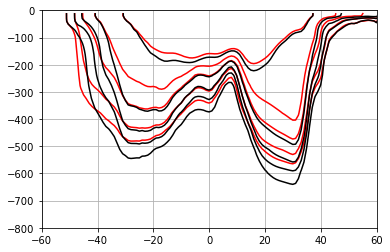

In [24]:
depc = np.arange(0,30)
#lonc = np.arange(200,240)
#toPl = np.nanmean(expaSig_SST[200:240,:,depc] - climaSig[200:240,:,depc],0) 
toPl = np.nanmean(expaSig_SST[140:170,:,depc],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPlc = np.nanmean(climaSig[140:170,:,depc],0)
ax = plt.axes()

# pick location

mylatc = [50, 40, 35, 32,29] # write in decreasing order
mysigs = np.nanmean(toPl[mylatc,0:5],1)
mysigsc = np.nanmean(toPlc[mylatc,0:5],1)
#levs = [ 30.5, 31, 31.5]
#levs2 = [29.8, 30.45, 31.15]
plt.contour(latq,-depq[depc], np.transpose(toPl),levels= mysigs, colors='red' )
plt.contour(latq,-depq[depc], np.transpose(toPlc), levels=mysigsc , colors='k')
plt.grid()
ax.set_xlim(-60,60)
ax.set_ylim(-800,0)

#plt.colorbar()

In [10]:

expaSig_SST = gsw.density.sigma0(expaS_SST, expaT_SST)
expaSig_indp = gsw.density.sigma0(expaS_indp, expaT_indp)
expaSig_natl = gsw.density.sigma0(expaS_natl, expaT_natl)
climaSig = gsw.density.sigma0(climaS, climaT)



array([  10.  ,   20.  ,   30.  ,   40.  ,   50.  ,   60.  ,   70.  ,
         80.01,   90.04,  100.15,  110.47,  121.27,  133.03,  146.45,
        162.49,  182.31,  207.16,  238.26,  276.68,  323.18,  378.18,
        441.68,  513.26,  592.16,  677.31,  767.49,  861.45,  958.03,
       1056.28, 1155.53, 1255.54, 1356.87, 1461.43, 1572.76, 1695.59,
       1834.68, 1993.62, 2174.45, 2378.  , 2604.5 , 2854.  , 3126.5 ,
       3422.  , 3740.5 , 4082.  , 4446.5 , 4834.  , 5244.5 , 5678.  ,
       6134.5 ])

(27.9, 23.5)

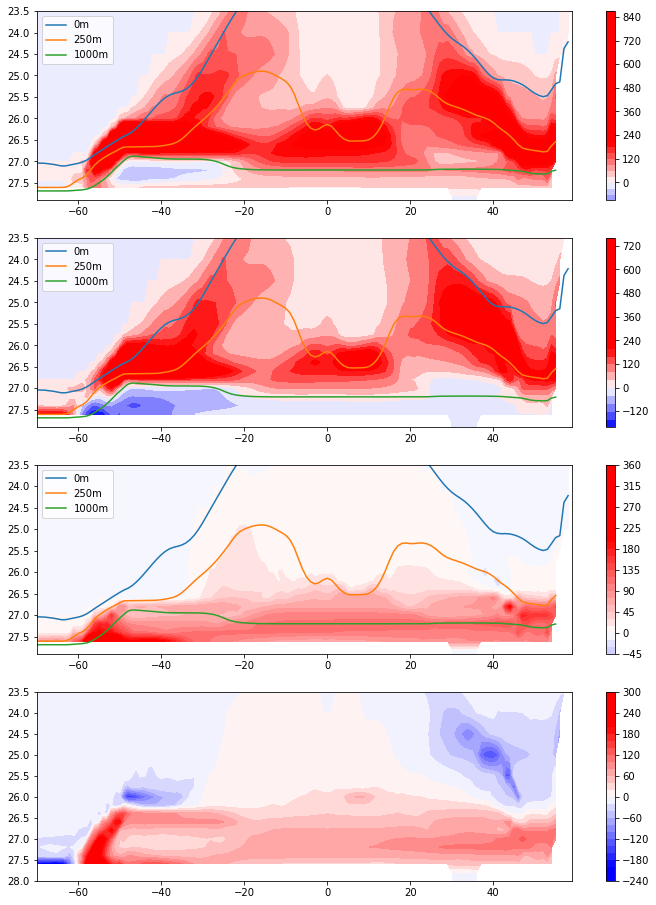

In [11]:
## Following up on a similar thread - here I am!
# I really just need to get density for 3 different runs - the NAtl, IndP, and dSST. 
# Then I'll start with a section like I did with the other one. Then it would also be nice to make a map, 
# though that is a little more work

fig, axs = plt.subplots(nrows = 4, figsize=(12,16))

mylon = 200
mylat = np.arange(10,140)


plt.set_cmap('bwr')
#siglevs = [ 24,25,26,26.5 ,27,27.3 ,27.7,27.8,27.85, 27.9, 27.95, 28, 28.1, 28.2]
myiso = np.concatenate([[23.5,24,24.5,25,25.5,25.75], np.arange(26,28.2,0.2)] )
#isodeps = np.interp(myiso, TP_ctl_sig, TP_ctl_sig.depth)
# this is fun, g
tlats = [15, 14 ,13, 12,11,10,8 ]
#conlevs = Sigm.isel(lon=mylon, lat= tlats, depth= range(0,4)).mean('depth') # use this non siglevs.
#warlevs = Sigw.isel(lon=mylon, lat= tlats, depth= range(0,4)).mean('depth')   

CTL_iso_deps = np.zeros([len(mylat), len(myiso)])
CTL_iso_O2 = np.zeros([len(mylat), len(myiso)])
SST_iso_deps = np.zeros([len(mylat), len(myiso)])
#SST_iso_O2 = np.zeros([len(mylat), len(myiso)])
INDP_iso_deps = np.zeros([len(mylat), len(myiso)])
NATL_iso_deps = np.zeros([len(mylat), len(myiso)])

#ctrla = CTL_age.age.isel(lon=mylon, lat=mylat, time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#warma = WARM_age.age.isel(lon=mylon, lat=mylat,time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#ctrlo = CTL_o2.o2.isel(lon=mylon, lat=mylat, time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#warmo = WARM_o2.o2.isel(lon=mylon, lat=mylat,time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)


for la in mylat: 
    ind = la - mylat[0]
    CTL_iso_deps[ind,:] = np.interp(myiso, climaSig[mylon, la, :], depq)
    #CTL_iso_O2[ind,:] = np.interp(myiso, Sigm.isel(lon=mylon, lat=la), ctrlo.isel(lat=ind))
    SST_iso_deps[ind,:] = np.interp(myiso, expaSig_SST[mylon, la, :], depq)
    INDP_iso_deps[ind,:] = np.interp(myiso, expaSig_indp[mylon, la, :], depq)
    NATL_iso_deps[ind,:] = np.interp(myiso, expaSig_natl[mylon, la, :], depq)
    #WARM_iso_O2[ind,:] = np.interp(myiso, Sigw.isel(lon=mylon, lat=la), warmo.isel(lat=ind))
    #WARM_iso_age[ind,:] = np.interp(myiso, Sigw.isel(lon=mylon, lat=la), warma.isel(lat=ind))
    #CTL_iso_age[ind,:] = np.interp(myiso, Sigm.isel(lon=mylon, lat=la), ctrla.isel(lat=ind))
    #isodeps = np.interp(myiso, TP_ctl_sig, TP_ctl_sig.depth)
    


#toPl = warm-ctrl#CTL_S.S.isel(lon=mylon, time = range(180,200), depth = range(0,18)).mean('time').plot(vmin=33.5, vmax=35)
#plt.contour(CTL_age.lat,-CTL_age.depth.isel(depth=range(0,18)), CTL_age.age.isel(lon=mylon, time = range(180,200), depth = range(0,18)).mean('time'), colors='k')
#plt.contour( ctrl.lat,-CTL_age.depth.isel(depth=range(0,18)), Sigm.isel(lon=mylon, lat=mylat,depth = range(0,18)), colors='k', levels= siglevs)

A = axs[0].contourf( latq[mylat], myiso, np.transpose(SST_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[0].invert_yaxis()
plt.colorbar(A, ax = axs[0])

B = axs[1].contourf( latq[mylat], myiso, np.transpose(INDP_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[1].invert_yaxis()
plt.colorbar(B, ax = axs[1])

C = axs[2].contourf( latq[mylat], myiso, np.transpose(NATL_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[2].invert_yaxis()
plt.colorbar(C, ax = axs[2])

D = axs[3].contourf( latq[mylat], myiso, np.transpose(SST_iso_deps) - np.transpose(INDP_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[3].invert_yaxis()
plt.colorbar(D, ax = axs[3])

#
#plt.title(CTL_o2.lon[mylon].data)
#
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[0].legend(['0m', '250m', '1000m'])
axs[0].set_ylim([27.9, 23.5 ])



axs[1].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[1].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[1].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[1].legend(['0m', '250m', '1000m'])
axs[1].set_ylim([27.9, 23.5 ])



axs[2].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[2].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[2].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[2].legend(['0m', '250m', '1000m'])
axs[2].set_ylim([27.9, 23.5 ])
#axs[1].plot(ctrl.lat, Sigm.isel(depth = 0, lon = mylon, lat =mylat))
#axs[1].set_ylim([27.9, 23.5 ])
#axs[2].plot(ctrl.lat, Sigm.isel(depth = 0, lon = mylon, lat =mylat))
#axs[2].set_ylim([27.9, 23.5 ])
#
#axs[0].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')
#axs[1].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')
#axs[2].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')




#plt.contourf( ctrl.lat,-CTL_age.depth.isel(depth=range(0,18)), toPl, vmin = -60., vmax= 60, levels=15)
#plt.colorbar()
#plt.ylim(-1500,0)

In [50]:
depq[17]
# 10 is 100 m approx
# 17 is 250 m
# 22 is 500 m 
# 28 is 1000 m 

238.25999999999996

In [171]:
## Last piece is that we need to see what will happen in terms of the geographic shape of the isopycal heave. 
# map view. double for loop because I can! 

#fig, axs = plt.subplots(nrows = 4, figsize=(12,12))

mylon = np.arange(130,300)
mylat = np.arange(20,140)


plt.set_cmap('bwr')
#siglevs = [ 24,25,26,26.5 ,27,27.3 ,27.7,27.8,27.85, 27.9, 27.95, 28, 28.1, 28.2]
myiso = np.concatenate([[23.5,24,24.5,25,25.5,25.75], np.arange(26,28.2,0.2)] )
oiso = 26.5
#isodeps = np.interp(myiso, TP_ctl_sig, TP_ctl_sig.depth)
# this is fun, g
#tlats = [15, 14 ,13, 12,11,10,8 ]
#conlevs = Sigm.isel(lon=mylon, lat= tlats, depth= range(0,4)).mean('depth') # use this non siglevs.
#warlevs = Sigw.isel(lon=mylon, lat= tlats, depth= range(0,4)).mean('depth')   

CTL_iso_map =  np.zeros([len(mylon), len(mylat)])
SST_iso_map =  np.zeros([len(mylon), len(mylat)])
INDP_iso_map = np.zeros([len(mylon), len(mylat)])
NATL_iso_map = np.zeros([len(mylon), len(mylat)])

#ctrla = CTL_age.age.isel(lon=mylon, lat=mylat, time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#warma = WARM_age.age.isel(lon=mylon, lat=mylat,time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#ctrlo = CTL_o2.o2.isel(lon=mylon, lat=mylat, time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)
#warmo = WARM_o2.o2.isel(lon=mylon, lat=mylat,time = range(180,200)).mean('time')#.plot(vmin=0.16, vmax=0.3)


for la in mylat: 
    ind = la - mylat[0]
    for lo in mylon: 
        ino = lo - mylon[0]
        CTL_iso_map[ino,ind] = np.interp(oiso,    climaSig[lo, la, :], depq)
        #CTL_iso_O2[ind,:] = np.interp(myiso, Sigm.isel(lon=mylon, lat=la), ctrlo.isel(lat=ind))
        SST_iso_map[ino,ind] = np.interp(oiso, expaSig_SST[lo, la, :], depq)
        INDP_iso_map[ino,ind] =np.interp(oiso, expaSig_indp[lo, la, :], depq)
        NATL_iso_map[ino,ind] =np.interp(oiso, expaSig_natl[lo, la, :], depq)
        #WARM_iso_O2[ind,:] = np.interp(myiso, Sigw.isel(lon=mylon, lat=la), warmo.isel(lat=ind))
        #WARM_iso_age[ind,:] = np.interp(myiso, Sigw.isel(lon=mylon, lat=la), warma.isel(lat=ind))
        #CTL_iso_age[ind,:] = np.interp(myiso, Sigm.isel(lon=mylon, lat=la), ctrla.isel(lat=ind))
        #isodeps = np.interp(myiso, TP_ctl_sig, TP_ctl_sig.depth)
    




#plt.contourf( ctrl.lat,-CTL_age.depth.isel(depth=range(0,18)), toPl, vmin = -60., vmax= 60, levels=15)
#plt.colorbar()
#plt.ylim(-1500,0)

<Figure size 432x288 with 0 Axes>

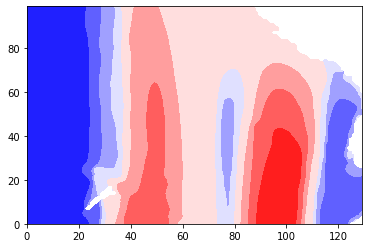

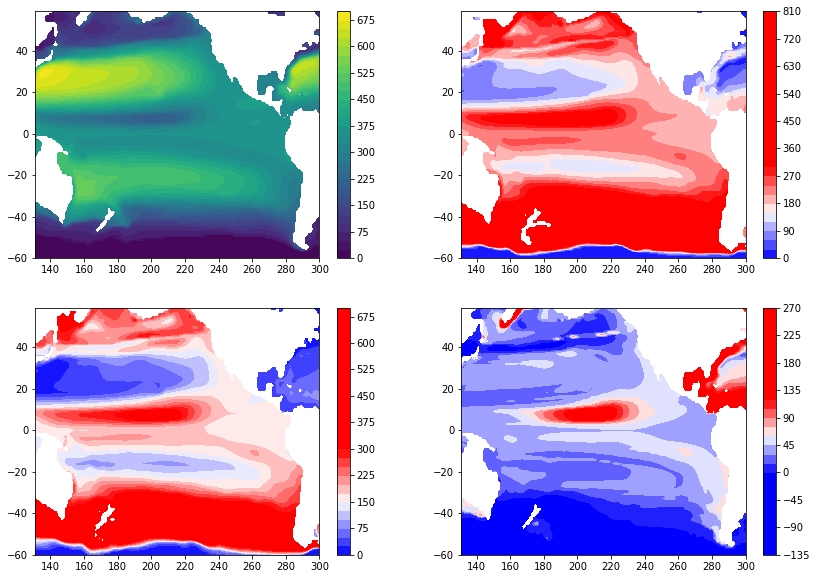

In [172]:
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(14,10))
plt.set_cmap('viridis')
A =axs[0,0].contourf(lonq[mylon], latq[mylat], np.transpose(CTL_iso_map), levels=30)
plt.set_cmap('bwr')
plt.colorbar(A, ax = axs[0,0])
B = axs[0,1].contourf(lonq[mylon], latq[mylat],np.transpose(SST_iso_map - CTL_iso_map ), vmin = 0, vmax = 300, levels = 30 )
plt.colorbar(B, ax = axs[0,1])
C = axs[1,0].contourf(lonq[mylon], latq[mylat],np.transpose(INDP_iso_map - CTL_iso_map ), vmin = 0, vmax = 300, levels = 30 )
plt.colorbar(C, ax = axs[1,0])
D = axs[1,1].contourf(lonq[mylon], latq[mylat],np.transpose(NATL_iso_map - CTL_iso_map ), vmin = 0, vmax = 120, levels = 30 )
plt.colorbar(D, ax = axs[1,1])

In [ ]:
#toPl = warm-ctrl#CTL_S.S.isel(lon=mylon, time = range(180,200), depth = range(0,18)).mean('time').plot(vmin=33.5, vmax=35)
#plt.contour(CTL_age.lat,-CTL_age.depth.isel(depth=range(0,18)), CTL_age.age.isel(lon=mylon, time = range(180,200), depth = range(0,18)).mean('time'), colors='k')
#plt.contour( ctrl.lat,-CTL_age.depth.isel(depth=range(0,18)), Sigm.isel(lon=mylon, lat=mylat,depth = range(0,18)), colors='k', levels= siglevs)

A = axs[0].contourf( latq[mylat], myiso, np.transpose(SST_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[0].invert_yaxis()
plt.colorbar(A, ax = axs[0])

B = axs[1].contourf( latq[mylat], myiso, np.transpose(INDP_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[1].invert_yaxis()
plt.colorbar(B, ax = axs[1])

C = axs[2].contourf( latq[mylat], myiso, np.transpose(NATL_iso_deps) - np.transpose(CTL_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[2].invert_yaxis()
plt.colorbar(C, ax = axs[2])

D = axs[3].contourf( latq[mylat], myiso, np.transpose(SST_iso_deps) - np.transpose(INDP_iso_deps) , vmin = -200, vmax = 200, levels = 30)
axs[3].invert_yaxis()
plt.colorbar(D, ax = axs[3])

#
#plt.title(CTL_o2.lon[mylon].data)
#
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[0].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[0].legend(['0m', '250m', '1000m'])
axs[0].set_ylim([27.9, 23.5 ])



axs[1].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[1].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[1].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[1].legend(['0m', '250m', '1000m'])
axs[1].set_ylim([27.9, 23.5 ])



axs[2].plot(latq[mylat], climaSig[mylon, mylat, 0])
axs[2].plot(latq[mylat], climaSig[mylon, mylat, 17])
axs[2].plot(latq[mylat], climaSig[mylon, mylat, 28])
axs[2].legend(['0m', '250m', '1000m'])
axs[2].set_ylim([27.9, 23.5 ])
#axs[1].plot(ctrl.lat, Sigm.isel(depth = 0, lon = mylon, lat =mylat))
#axs[1].set_ylim([27.9, 23.5 ])
#axs[2].plot(ctrl.lat, Sigm.isel(depth = 0, lon = mylon, lat =mylat))
#axs[2].set_ylim([27.9, 23.5 ])
#
#axs[0].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')
#axs[1].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')
#axs[2].contour( ctrl.lat, myiso, np.transpose(WARM_iso_deps) - np.transpose(CTL_iso_deps), levels = [75,200], colors = 'k')




In [ ]:
## What I'm trying to do here is closely investigate how the subsurface Pacific ocean looks
# and responds! htis is very interesting! 
# I mostly care about zonal velocity. 



In [12]:
climaU_natl = np.load( 'MITgcm_qmeans/climaU_natl.npy')
expaU_natl = np.load( 'MITgcm_qmeans/expaU_natl.npy')
expaU_indp = np.load( 'MITgcm_qmeans/expaU_indp.npy')


<ipython-input-13-6607dcb0ac18>:5: RuntimeWarning: Mean of empty slice
  toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine.
<ipython-input-13-6607dcb0ac18>:6: RuntimeWarning: Mean of empty slice
  toPlc = np.nanmean(climaT[lonc,:,:],0)


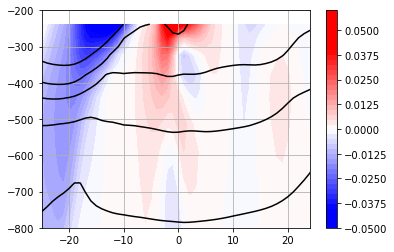

In [13]:
depc = np.arange(17,30)
latc = np.arange(55,105)
lonc = np.arange(230,240)
#toPl = np.nanmean(expaSig_SST[200:240,:,depc] - climaSig[200:240,:,depc],0) 
toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPlc = np.nanmean(climaT[lonc,:,:],0)
toPl = toPl[:,depc] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPlc = toPlc[:,depc]


ax = plt.axes()

# pick location

#mylatc = [50, 40, 35, 32,29] # write in decreasing order
#mysigs = np.nanmean(toPl[mylatc,0:5],1)
#mysigsc = np.nanmean(toPlc[mylatc,0:5],1)
#levs = [ 30.5, 31, 31.5]
#levs2 = [29.8, 30.45, 31.15]
A = plt.contourf(latq[latc],-depq[depc], np.transpose(toPl[latc,:]), vmin = -0.04, vmax = 0.04, levels =50)
plt.contour(latq,-depq[depc], np.transpose(toPlc), levels = [6, 8, 10,12,15,] , colors='k')
plt.grid()
ax.set_xlim(latc[0]-80, latc[-1]-80)
ax.set_ylim(-800,-200)
plt.colorbar(A)

#plt.colorbar()

<ipython-input-14-4994bd90ac08>:8: RuntimeWarning: Mean of empty slice
  toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine.
<ipython-input-14-4994bd90ac08>:9: RuntimeWarning: Mean of empty slice
  toPld = np.nanmean(expaU_SST[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0)
<ipython-input-14-4994bd90ac08>:14: RuntimeWarning: Mean of empty slice
  toPld2 = np.nanmean(expaU_indp[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0)


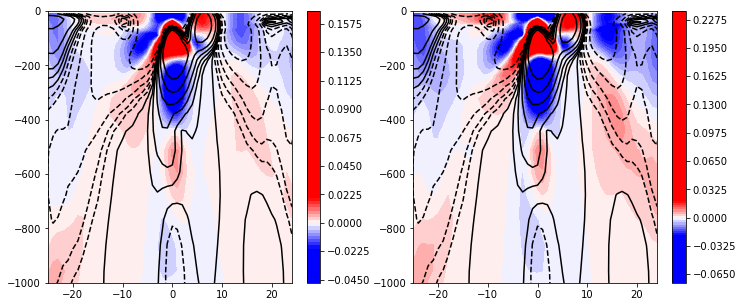

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))


depc = np.arange(0,35)
latc = np.arange(55,105)
lonc = np.arange(180,220)
#toPl = np.nanmean(expaSig_SST[200:240,:,depc] - climaSig[200:240,:,depc],0) 
toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld = np.nanmean(expaU_SST[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0) 
toPl = toPl[:,depc] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld = toPld[:,depc]

#toPl2 = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld2 = np.nanmean(expaU_indp[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0) 
#toPl2 = toPl2[:,depc] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld2 = toPld2[:,depc]



# pick location

#mylatc = [50, 40, 35, 32,29] # write in decreasing order
#mysigs = np.nanmean(toPl[mylatc,0:5],1)
#mysigsc = np.nanmean(toPlc[mylatc,0:5],1)
#levs = [ 30.5, 31, 31.5]
#levs2 = [29.8, 30.45, 31.15]
A = axs[0].contourf(latq[latc],-depq[depc], np.transpose(toPld[latc,:]), vmin = -0.02, vmax = 0.02, levels =100)
axs[0].contour(latq,-depq[depc], np.transpose(toPl), levels = [-0.08, -0.04,-0.02,-0.01,-0.005,0,0.005, 0.01, 0.02, 0.04, 0.08, 0.16] , colors='k')

B = axs[1].contourf(latq[latc],-depq[depc], np.transpose(toPld2[latc,:]), vmin = -0.02, vmax = 0.02, levels =150)
axs[1].contour(latq,-depq[depc], np.transpose(toPl), levels = [-0.08, -0.04,-0.02,-0.01,-0.005,0,0.005, 0.01, 0.02, 0.04, 0.08, 0.16] , colors='k')

#plt.grid()
axs[0].set_xlim(latc[0]-80, latc[-1]-80)
axs[0].set_ylim(-1000,0)
axs[1].set_xlim(latc[0]-80, latc[-1]-80)
axs[1].set_ylim(-1000,0)
plt.colorbar(A, ax = axs[0])
plt.colorbar(B, ax = axs[1])

#plt.colorbar()

In [153]:
# Ok I think I have a decent idea that it's just the SEC and then ... the big westward flow at 10-15 N
# that shoal. (What's that called - the NEC. 
# OK the shoaling of the NEC and SEC. Yes, that makes sense! 
# that has a geostrophic implication by thermal wind. 
#(Does it have a relatively large implicaiton because f is small ... try to remember? Yes! No .. )

# Ok that was not too bad. 

# basically, yes, INDP forcing leads to the shoaling of the NEC and SEC. 
# what's the actual thermal wind equation ?? 

# du/dz ~ 1/rho0 * g/f * dsigma/dy 

# Yeah it pretty much makes sense - that's the story! I think we can write this pretty quickly! 
# It's a nice story. I think we can do this with heat and oxygen ... should be fine! 
# Um. Ok! This is key. There's a lot of juice here. 

# A few things to really show with more clarity: 
# One - that the isopycnals do get less steep in the two cases. I think I can easily show that. 

# Two - a spatial map showing the spread of velocity change (say at 400 m?). Very easy too. 
# then figure out how to communicate this! first step is just a follow up email.  

# Thank you LORD! this is exciting! I do think we can understand this piece that people didn't 
# really understand before! This is so cool! Thank you! 

<ipython-input-170-24db2352f6e7>:12: RuntimeWarning: Mean of empty slice
  toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine.
<ipython-input-170-24db2352f6e7>:13: RuntimeWarning: Mean of empty slice
  toPld = np.nanmean(expaU_indp[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0)
<ipython-input-170-24db2352f6e7>:18: RuntimeWarning: Mean of empty slice
  Sigc = np.nanmean(climaSig[lonc,:,:] ,0)
<ipython-input-170-24db2352f6e7>:19: RuntimeWarning: Mean of empty slice
  SigW = np.nanmean(expaSig_indp[lonc,:,:] ,0)


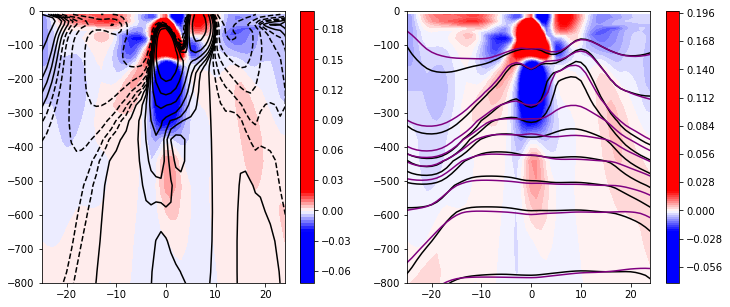

In [170]:
# panel A shows the U dif vs background, same as before. 
# panel B shows the U dif in shading, but the isopycnals


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))


depc = np.arange(0,30)
latc = np.arange(55,105)
lonc = np.arange(200,250)
#toPl = np.nanmean(expaSig_SST[200:240,:,depc] - climaSig[200:240,:,depc],0) 
toPl = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld = np.nanmean(expaU_indp[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0) 
toPl = toPl[:,depc] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld = toPld[:,depc]


Sigc = np.nanmean(climaSig[lonc,:,:] ,0)
SigW = np.nanmean(expaSig_indp[lonc,:,:] ,0)

Sigc = Sigc[:,depc]
SigW = SigW[:,depc]

#toPl2 = np.nanmean(climaU_natl[lonc, :,:],0) #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
#toPld2 = np.nanmean(expaU_i[lonc,:,:],0) - np.nanmean(climaU_natl[lonc,:,:],0) 
#toPl2 = toPl2[:,depc] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
#toPld2 = toPld2[:,depc]



# pick location

mydepc = [10,15,18,19,20,21,22, 23,25] # write in decreasing order

mysigc = Sigc[latc[0]+40,mydepc]
mysigW = SigW[latc[0]+40,mydepc]
#levs = [ 30.5, 31, 31.5]
#levs2 = [29.8, 30.45, 31.15]
A = axs[0].contourf(latq[latc],-depq[depc], np.transpose(toPld[latc,:]), vmin = -0.02, vmax = 0.02, levels =100)
axs[0].contour(latq,-depq[depc], np.transpose(toPl), levels = [-0.08, -0.04,-0.02,-0.01,-0.005,0,0.005, 0.01, 0.02, 0.04, 0.08, 0.16] , colors='k')

B = axs[1].contourf(latq[latc],-depq[depc], np.transpose(toPld[latc,:]), vmin = -0.02, vmax = 0.02, levels =150)
axs[1].contour(latq,-depq[depc], np.transpose(Sigc), levels = mysigc , colors='k')
axs[1].contour(latq,-depq[depc], np.transpose(SigW), levels = mysigW , colors='purple')

#plt.grid()
axs[0].set_xlim(latc[0]-80, latc[-1]-80)
axs[0].set_ylim(-800,0)
axs[1].set_xlim(latc[0]-80, latc[-1]-80)
axs[1].set_ylim(-800,0)
plt.colorbar(A, ax = axs[0])
plt.colorbar(B, ax = axs[1])

#plt.colorbar()

In [ ]:
## this is exciting! Neat. 
# Well, I'm not sure what's next. I think the idea is that ... we're close! 


276.67999999999995


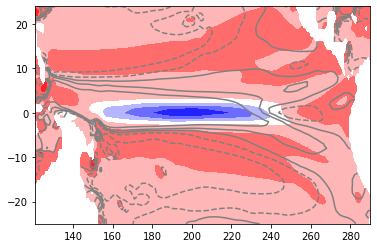

In [184]:
mapd = 18
latc = np.arange(55,105)
lonc = np.arange(120,290)
toPl =  climaU_natl[lonc,:,:] 
toPld = expaU_indp[lonc,:,:]- climaU_natl[lonc,:,:] 
toPl = toPl[:,:,mapd] #- climaSig[200:240,:,depc],0) # was 200:230, that's fine. 
toPld = toPld[:,:,mapd]

plt.contour(lonq[lonc], latq[latc], np.transpose(toPl[:,latc]), [-0.03, -0.01, 0, 0.01,0.03], colors= 'gray')
plt.contourf(lonq[lonc], latq[latc], np.transpose(toPld[:,latc]))
print(depq[mapd])